# E.ON Future Lab - Day Ahead Electricity Price Forecasting

## Background
You are in control of a fleet of batteries and wish to operate the batteries in the optimal way to make a profit. As part of your operations, it is ideal if
you can predict the day ahead electricity prices before they are published. Day-ahead electricity prices in Europe are the prices at which electricity is
bought and sold a day before it is actually consumed. These prices help market participants plan their electricity production and consumption based on
anticipated supply and demand, as well as other factors like weather conditions and regulations.
Day-ahead electricity prices for day D, are determined through an auction process and are typically published on the previous day, D-1. The prices are
usually made available around midday to provide market participants with sufficient time to plan their electricity activities for the upcoming day.
By predicting the day-ahead electricity prices before the auction takes place you can gain an advantage. It would enable you to make informed
decisions regarding trading strategies, potentially leading to improved profitability and better utilization of your battery fleet.

## Modeling Task

Your task is to develop a predictive model that forecasts day-ahead electricity prices in the Germany -LU region. The model should utilize historical
data and weather information.
You can access get data about prices, energy production and consumption from the ENTSOE transparency https://transparency.entsoe.eu/
The data can be accessed through this python library: https://pypi.org/project/entsoe-py/0.2.2/ and the provided token.
From the ENTSOE website you will have access to:
Actual load data, Load forecast data, Actual generation data, Generation forecast data, Wind and solar generation forecast
When predicting the day ahead prices for day D, only the actual load and generation data for day D-2, will be available, this should be taken into
account during pre-processing. The available load and generation forecast will include values up to day D. The ENTSOE service contains many
different data columns. For this task only use load and generation data, ignore transmission, etc.
You should use data from 01.01.2023 to up and including the 01.06.23 for training and validation.
Weather data for Berlin, Frankfurt and Munich can also be used in the models, it can accessed with https://pypi.org/project/dwdweather2/ or
alternative.

# Table of Contents
1. Exploration and Cleaning
    1. Load Datasets
        * Energy Data
        * Weather Data
    2. Merge Energy and Weather Datasets 
 
2. Visualization and Analysis
    1. Useful Visualizations
    2. Stationary Tests
    3. Auto Correlation, Partial Auto Correlation and Cross-Corelation
    

3. Feature Engineering
    1. Feature Generation
    2. Feature Selection

4. Modeling 
    1. XGBoost
    2. LightGBM
    2. LSTM
    3. CNN
    4. CNN-LSTM
    5. Time Distributed MLP 

5. Evaluation

In [1]:
import logging
import time
from contextlib import contextmanager
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
import multiprocessing_logging
from src.utils._get_data import DataHandler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
pd.options.display.max_columns = None
%matplotlib inline
# after setting up your logger
logging.basicConfig(level=logging.INFO)
multiprocessing_logging.install_mp_handler()

2023-06-22 17:39:14.552346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 17:39:15.156211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Create a context manager for timing sections of code
@contextmanager
def log_time(section_name: str):
    """
    Context manager for timing sections of your code. 
    It logs completion time on successful completion of the with block.
    """
    start_time = time.time()
    yield
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info(f"{section_name} completed in {elapsed_time} seconds")


# 1. Exploration and Cleaning

We have different datasets that contain load and generation and day ahead electricy prices information. Additionaly we have historical weather data for the following cities : Munich, Berlin, FRankfurt between the dates 01.01.2023 and 01.06.2023

## 1.1. Load Datasets
Please see the DataHandler class from the following path for detailed implementation
* `src.utils._get_data.py -> DataHandler()`

In [3]:
# Describe the data you want to get
data_names = [
    'load_data',
    #'load_forecast',
    'generation_data',
    #'generation_forecast',
    #'wind_and_solar_forecast',
    'day_ahead_prices',
    'weather_data'
]

# Describe the country code, start and end dates
country_code = 'DE_LU'
start = pd.Timestamp('2022-12-01', tz='Europe/Berlin')
end = pd.Timestamp('2023-06-01', tz='Europe/Berlin')

In [4]:
# Added multiprocessing to speed up the data loading process

# function to load a single dataset
def load_single_dataset(args):
    dataset_name, data_handler = args
    try:
        with log_time(dataset_name):
            df = data_handler._get_data(dataset_name)
            logging.info(f"{dataset_name} data retrieved successfully")
            return dataset_name, df
    except Exception as e:
        logging.error(f"Error while loading {dataset_name}: {e}")
        raise e

def load_dataset():
    df_dict = {} # Dictionary to store the dataframes
    try:
        with log_time("DataHandler"):
            data_handler = DataHandler()
            logging.info("DataHandler object created successfully")
            data_handler._set_data_settings(country_code, start, end)
            logging.info("DataHandler settings set successfully")
            with Pool(cpu_count()) as pool:
                results = pool.map(load_single_dataset, [(name, data_handler) for name in data_names])
            for dataset_name, df in results:
                df_dict[dataset_name] = df
    except Exception as e:
        logging.error(f"Error while creating DataHandler: {e}")
        raise e

    return df_dict

In [5]:
df_dict = load_dataset()

INFO:root:DataHandler object created successfully
INFO:root:DataHandler settings set successfully
/home/mamur/EON/forecast-electricity-prices/src/utils/_get_data.py:80: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(self.weather_data_path, index_col=0, parse_dates=True)
INFO:root:weather_data data retrieved successfully
INFO:root:weather_data completed in 0.07670760154724121 seconds
INFO:root:load_data data retrieved successfully
INFO:root:load_data completed in 4.456303596496582 seconds
INFO:root:day_ahead_prices data retrieved successfully
INFO:root:day_ahead_prices completed in 16.47520422935486 seconds
INFO:root:generation_data data retrieved successfully
INFO:root:generation_data completed in 63.09286713600159 seconds
INFO:root:DataHandler completed in 63.30575180053711 seconds


In [6]:
# Prin the type of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {type(df)}")

load_data: <class 'pandas.core.frame.DataFrame'>
generation_data: <class 'pandas.core.frame.DataFrame'>
day_ahead_prices: <class 'pandas.core.frame.DataFrame'>
weather_data: <class 'pandas.core.frame.DataFrame'>


### 1.1.1 Energy Dataset

In [7]:
energy_datasets = ['load_data', 'load_forecast', 'generation_data', 'generation_forecast', 'wind_and_solar_forecast', 'day_ahead_prices']

In [8]:
# print the columns of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        print(f"{dataset_name}: {df.columns}")

load_data: Index(['Actual Load'], dtype='object')
generation_data: MultiIndex([(                        'Biomass',  'Actual Aggregated'),
            (      'Fossil Brown coal/Lignite',  'Actual Aggregated'),
            (                     'Fossil Gas',  'Actual Aggregated'),
            (               'Fossil Hard coal',  'Actual Aggregated'),
            (                     'Fossil Oil',  'Actual Aggregated'),
            (                     'Geothermal',  'Actual Aggregated'),
            (           'Hydro Pumped Storage',  'Actual Aggregated'),
            (           'Hydro Pumped Storage', 'Actual Consumption'),
            ('Hydro Run-of-river and poundage',  'Actual Aggregated'),
            (          'Hydro Water Reservoir',  'Actual Aggregated'),
            (                        'Nuclear',  'Actual Aggregated'),
            (                          'Other',  'Actual Aggregated'),
            (                'Other renewable',  'Actual Aggregated'),
          

In [9]:
# print the frequency and length of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        print(f"{dataset_name}: {df.index.freq} {len(df)}")

load_data: <15 * Minutes> 17468
generation_data: <15 * Minutes> 17468
day_ahead_prices: <60 * Minutes> 4368


Since our target variable has a hourly frequency we can resample others to have hourly frequency also

In [10]:
# resample the data to hourly frequency
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        df_dict[dataset_name] = df.resample('H').mean()


In [11]:
# print the frequency and length of the each dataset in the dictionary
for dataset_name, df in df_dict.items():
    if dataset_name in energy_datasets:
        print(f"{dataset_name}: {df.index.freq} {len(df)}")

load_data: <Hour> 4367
generation_data: <Hour> 4367
day_ahead_prices: <Hour> 4368


In [12]:
# print the data types of each dataset in the dictionary
for dataset_name, df in df_dict.items():
    print(f"{dataset_name}: {df.dtypes}")

load_data: Actual Load    float64
dtype: object
generation_data: Biomass                          Actual Aggregated     float64
Fossil Brown coal/Lignite        Actual Aggregated     float64
Fossil Gas                       Actual Aggregated     float64
Fossil Hard coal                 Actual Aggregated     float64
Fossil Oil                       Actual Aggregated     float64
Geothermal                       Actual Aggregated     float64
Hydro Pumped Storage             Actual Aggregated     float64
                                 Actual Consumption    float64
Hydro Run-of-river and poundage  Actual Aggregated     float64
Hydro Water Reservoir            Actual Aggregated     float64
Nuclear                          Actual Aggregated     float64
Other                            Actual Aggregated     float64
Other renewable                  Actual Aggregated     float64
Solar                            Actual Aggregated     float64
                                 Actual Consumption  

As we can see, all variables are numeric (float64)

Now we can merge all energy datasets and get started with the exploration and cleaning procedure

In [13]:
df_energy_all = pd.concat([df_dict['load_data'], df_dict['generation_data'], df_dict['day_ahead_prices']], axis=1)

In [14]:
start_date = '2023-01-01'
df_energy= df_energy_all[df_energy_all.index >= start_date]

In [15]:
df_energy.head()

Actual Load  (Biomass, Actual Aggregated)  \
2023-01-01 00:00:00+01:00     38931.75                           NaN   
2023-01-01 01:00:00+01:00     38314.00                           NaN   
2023-01-01 02:00:00+01:00     37470.25                           NaN   
2023-01-01 03:00:00+01:00     36497.75                           NaN   
2023-01-01 04:00:00+01:00     36065.00                           NaN   

                           (Fossil Brown coal/Lignite, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                         3859.25   
2023-01-01 01:00:00+01:00                                         3866.50   
2023-01-01 02:00:00+01:00                                         3860.25   
2023-01-01 03:00:00+01:00                                         3864.75   
2023-01-01 04:00:00+01:00                                         3841.00   

                           (Fossil Gas, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                          2469.00   
2023-01-01 01:00:00+01:00                          2292.25   
2023-01-01 02:00:00+01:00                          2240.50   
2023-01-01 03:00:00+01:00                          2243.75   
2023-01-01 04:00:00+01:00                          2254.75   

                           (Fossil Hard coal, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                2067.50   
2023-01-01 01:00:00+01:00                                2052.00   
2023-01-01 02:00:00+01:00                                2034.25   
2023-01-01 03:00:00+01:00                                2037.00   
2023-01-01 04:00:00+01:00                                2040.25   

                           (Fossil Oil, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                              8.0   
2023-01-01 01:00:00+01:00                              8.0   
2023-01-01 02:00:00+01:00                              8.0   
2023-01-01 03:00:00+01:00                              8.0   
2023-01-01 04:00:00+01:00                              8.0   

                           (Geothermal, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                            26.50   
2023-01-01 01:00:00+01:00                            26.00   
2023-01-01 02:00:00+01:00                            26.00   
2023-01-01 03:00:00+01:00                            26.00   
2023-01-01 04:00:00+01:00                            25.25   

                           (Hydro Pumped Storage, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                      42.75   
2023-01-01 01:00:00+01:00                                     172.50   
2023-01-01 02:00:00+01:00                                     163.50   
2023-01-01 03:00:00+01:00                                     161.00   
2023-01-01 04:00:00+01:00                                     160.50   

                           (Hydro Pumped Storage, Actual Consumption)  \
2023-01-01 00:00:00+01:00                                     1933.50   
2023-01-01 01:00:00+01:00                                     2025.50   
2023-01-01 02:00:00+01:00                                     3636.75   
2023-01-01 03:00:00+01:00                                     4385.50   
2023-01-01 04:00:00+01:00                                     4411.50   

                           (Hydro Run-of-river and poundage, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                            1215.00      
2023-01-01 01:00:00+01:00                                            1212.50      
2023-01-01 02:00:00+01:00                                            1211.00      
2023-01-01 03:00:00+01:00                                            1208.75      
2023-01-01 04:00:00+01:00                                            1204.25      

                           (Hydro Water Reservoir, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                       82.00   
2023-01-01 01:00:00+01:00                                       36.25   
2023-01-01 02

In [16]:
df_energy.describe().round(2)

Actual Load  (Biomass, Actual Aggregated)  \
count      3623.00                       3335.00   
mean      55028.61                       4679.21   
std        8663.51                        200.08   
min       35314.50                       4227.00   
25%       47797.75                       4527.75   
50%       54865.50                       4659.00   
75%       62575.88                       4812.38   
max       72296.50                       5190.25   

       (Fossil Brown coal/Lignite, Actual Aggregated)  \
count                                         3623.00   
mean                                          9731.93   
std                                           3597.48   
min                                           3157.75   
25%                                           6745.38   
50%                                           9540.00   
75%                                          12879.38   
max                                          16450.75   

       (Fossil Gas, Actual Aggregated)  (Fossil Hard coal, Actual Aggregated)  \
count                          3623.00                                3623.00   
mean                           6134.50                                5684.60   
std                            2901.14                                3846.52   
min                            1936.50                                 994.50   
25%                            3989.62                                2352.88   
50%                            5401.00                                4702.25   
75%                            7600.00                                7961.00   
max                           16111.75                               15240.50   

       (Fossil Oil, Actual Aggregated)  (Geothermal, Actual Aggregated)  \
count                          3623.00                          3623.00   
mean                             68.02                            24.71   
std                             115.03                             3.63   
min                               8.00                            15.00   
25%                               8.00                            22.00   
50%                               8.00                            23.50   
75%                              34.38                            28.00   
max                             564.25                            32.00   

       (Hydro Pumped Storage, Actual Aggregated)  \
count                                    3623.00   
mean                                     1381.95   
std                                      1797.60   
min                                         0.00   
25%                                       191.62   
50%                                       521.25   
75%                                      1845.25   
max                                      9163.00   

       (Hydro Pumped Storage, Actual Consumption)  \
count                                     3623.00   
mean                                      1751.92   
std                                       2070.96   
min                                          0.00   
25%                                        222.88   
50%                                        728.75   
75%                                       2750.00   
max                                       8420.50   

       (Hydro Run-of-river and poundage, Actual Aggregated)  \
count                                            3623.00      
mean                                             1387.92      
std                                               297.14      
min                                               976.50      
25%                                              1166.75      
50%                                              1282.75      
75%                                              1492.00      
max                                              2079.00      

       (Hydro Water Reservoir, Actual Aggregated)  \
count                                     3623.00 

We will drop all the columns that are constituted by zeroes, as they are unusable. 

In [17]:
# Create a list of column labels to drop
columns_to_drop = [('Solar', 'Actual Consumption'), ('Wind Onshore', 'Actual Consumption')]
# Drop the specified columns
df_energy = df_energy.drop(columns_to_drop, axis=1)


In [18]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3624 entries, 2023-01-01 00:00:00+01:00 to 2023-06-01 00:00:00+02:00
Freq: H
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Actual Load                                           3623 non-null   float64
 1   (Biomass, Actual Aggregated)                          3335 non-null   float64
 2   (Fossil Brown coal/Lignite, Actual Aggregated)        3623 non-null   float64
 3   (Fossil Gas, Actual Aggregated)                       3623 non-null   float64
 4   (Fossil Hard coal, Actual Aggregated)                 3623 non-null   float64
 5   (Fossil Oil, Actual Aggregated)                       3623 non-null   float64
 6   (Geothermal, Actual Aggregated)                       3623 non-null   float64
 7   (Hydro Pumped Storage, Actual Aggregated)             3623 non-null   float64
 8   (H

In [19]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 938 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [20]:
df_energy.isna().sum()

Actual Load                                               1
(Biomass, Actual Aggregated)                            289
(Fossil Brown coal/Lignite, Actual Aggregated)            1
(Fossil Gas, Actual Aggregated)                           1
(Fossil Hard coal, Actual Aggregated)                     1
(Fossil Oil, Actual Aggregated)                           1
(Geothermal, Actual Aggregated)                           1
(Hydro Pumped Storage, Actual Aggregated)                 1
(Hydro Pumped Storage, Actual Consumption)                1
(Hydro Run-of-river and poundage, Actual Aggregated)      1
(Hydro Water Reservoir, Actual Aggregated)                1
(Nuclear, Actual Aggregated)                            633
(Other, Actual Aggregated)                                1
(Other renewable, Actual Aggregated)                      1
(Solar, Actual Aggregated)                                1
(Waste, Actual Aggregated)                                1
(Wind Offshore, Actual Aggregated)      

As we can see, there are some missing values in Biomass and Nuclear columns. Therefore its a good idea to visualize and see if we can do something for them 

In [21]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        if end is not None:
            ax.plot(df[column][start:end], label=label)
        else:
            ax.plot(df[column][start:], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

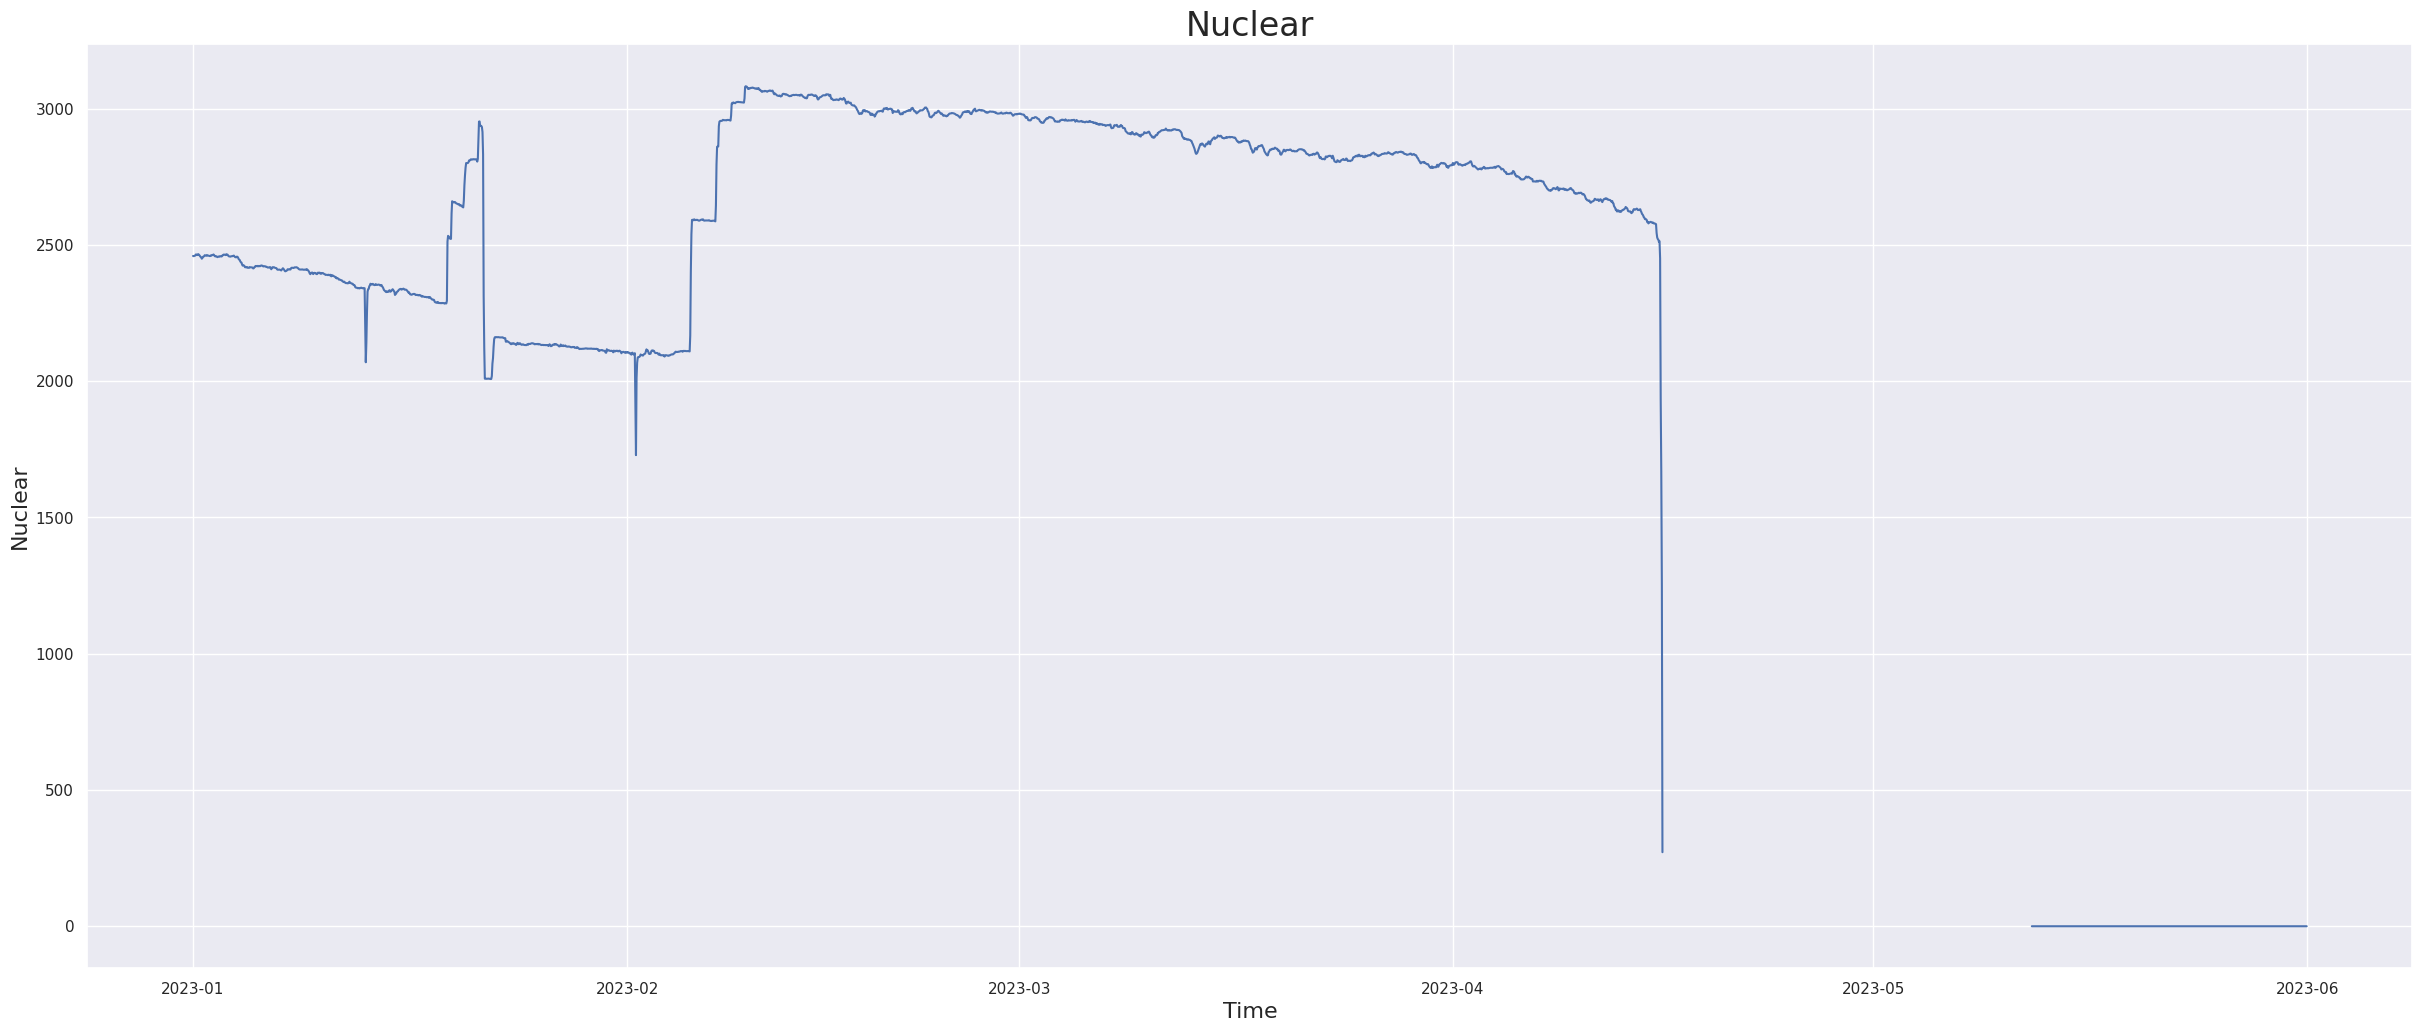

In [22]:
nuclear_col = ('Nuclear', 'Actual Aggregated')
ax = plot_series(df=df_energy, column=nuclear_col, ylabel='Nuclear',
                 title='Nuclear')
plt.show()

As we can see the missin values are between mid of april and mid of may. On the other hand interestigly after the may it is always 0. So there is my shutdown in nuclear power plant in germany ? 
 * BINGO ! 
    * The last three nuclear power plants in Germany were shut down on 15 April 2023: Isar 2, Emsland and Neckarwestheim 2. Their shutdown had been planned for 31 December 2022. Due to the energy crisis, the three nuclear power plants continued operation in stretch-out mode until 15 April 2023 at the latest. ( https://www.base.bund.de/EN/ns/nuclear-phase-out/nuclear-phase-out_node.html#:~:text=The%20last%20three%20nuclear%20power%20plants%20in%20Germany%20were%20shut,April%202023%20at%20the%20latest.)

So now it make sense. We can just impute these values to 0 


In [23]:
df_energy[nuclear_col].fillna(0, inplace=True)

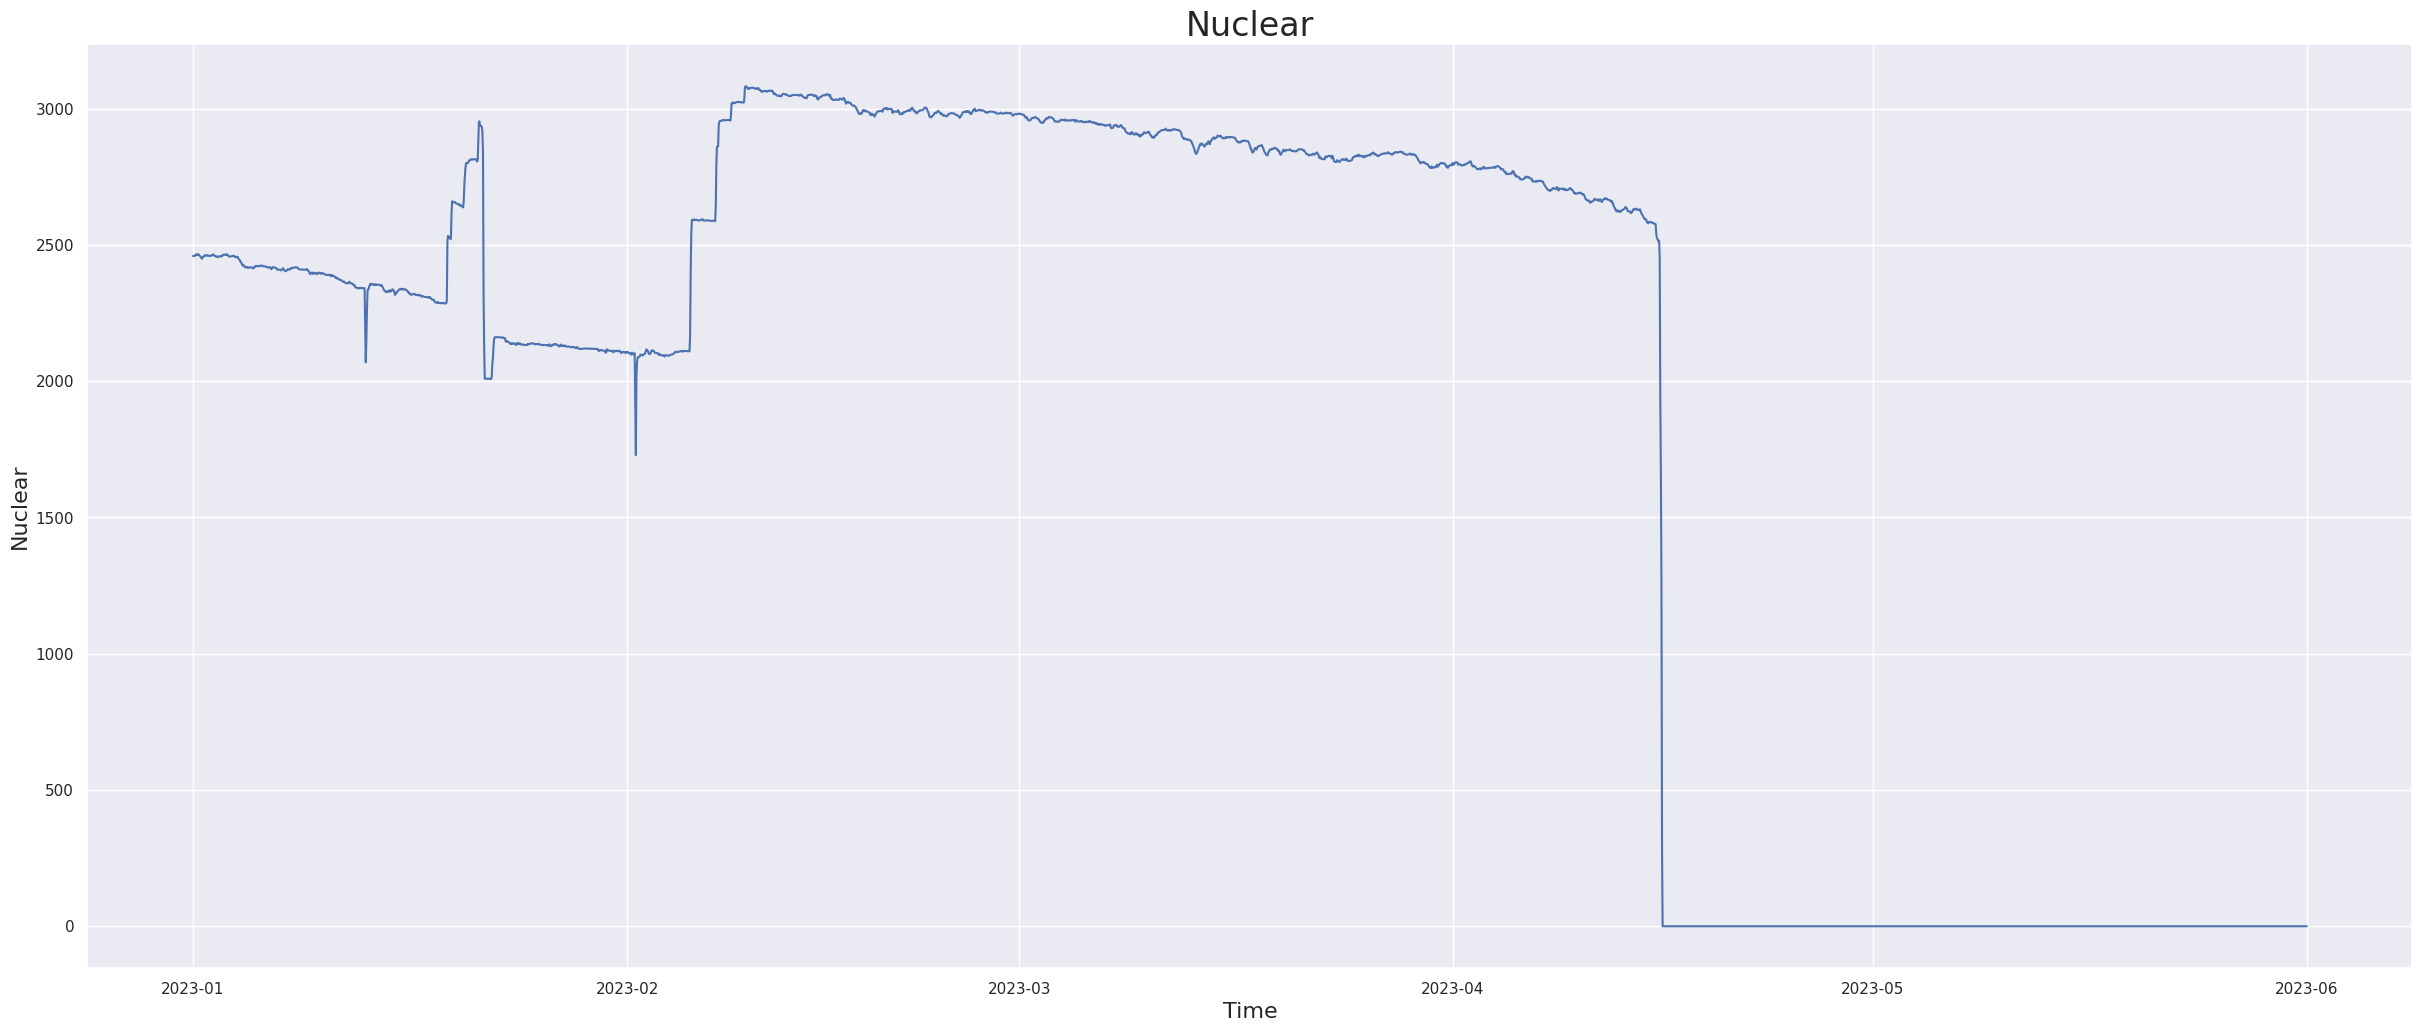

In [24]:
ax = plot_series(df=df_energy, column=nuclear_col, ylabel='Nuclear',
                 title='Nuclear')
plt.show()

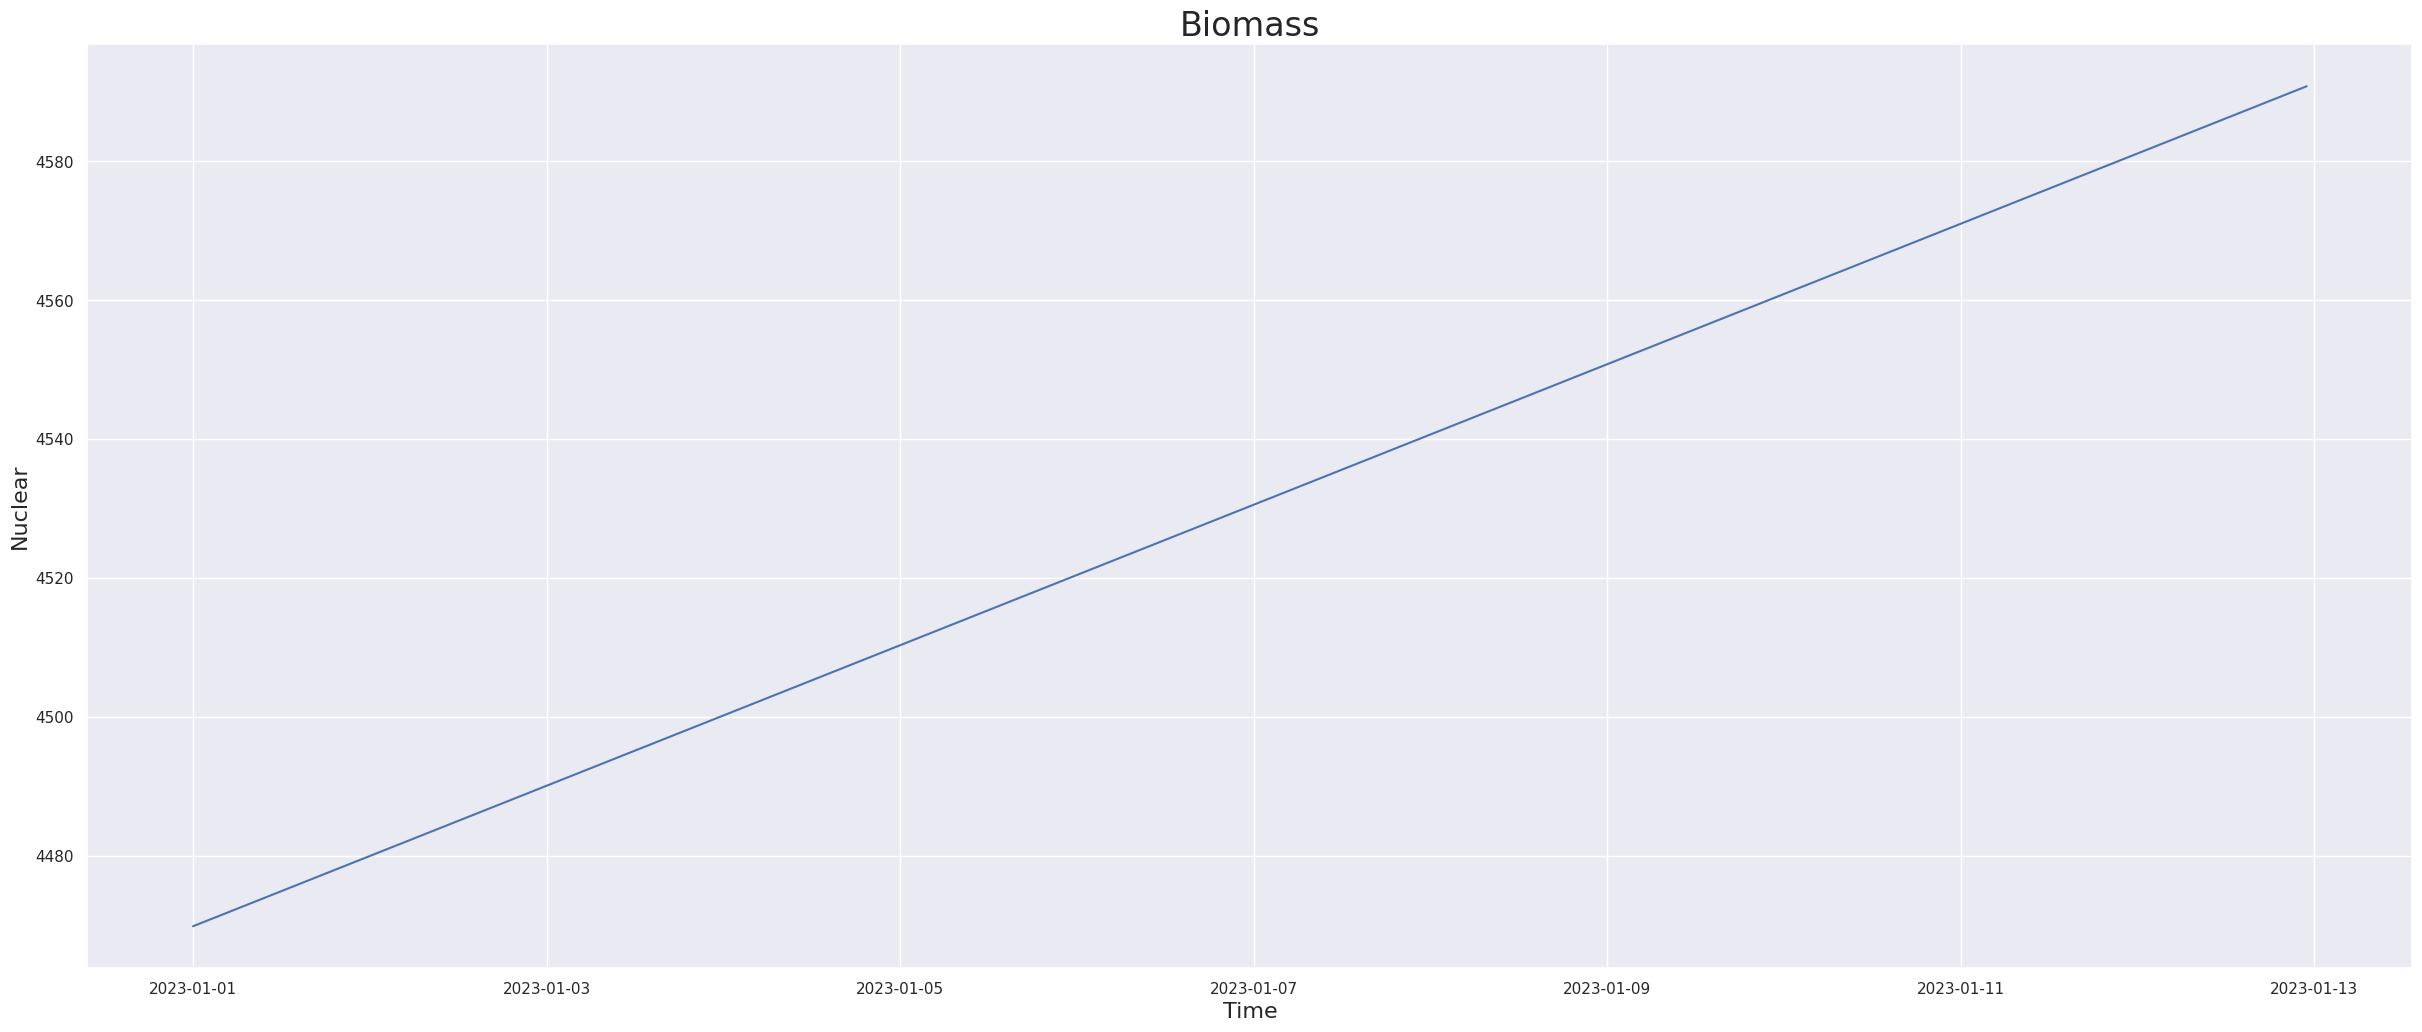

In [75]:
# Now lets have a look at the Biomass data
biomass_col = ('Biomass', 'Actual Aggregated')
ax = plot_series(df=df_energy, column=biomass_col, ylabel='Nuclear',
                 title='Biomass', end=24*12)
plt.show()

As you can see we do not have data for the first 13 days. Therefore it make sense get back data and use interpolation to fill thise values 

TODO : Find another method to fill it out

In [26]:
df_energy_all[biomass_col].interpolate(method='linear', limit_direction='backward', inplace=True, axis=0)

In [27]:
biomass_values = df_energy_all[biomass_col]
df_energy[biomass_col].fillna(biomass_values, inplace=True)

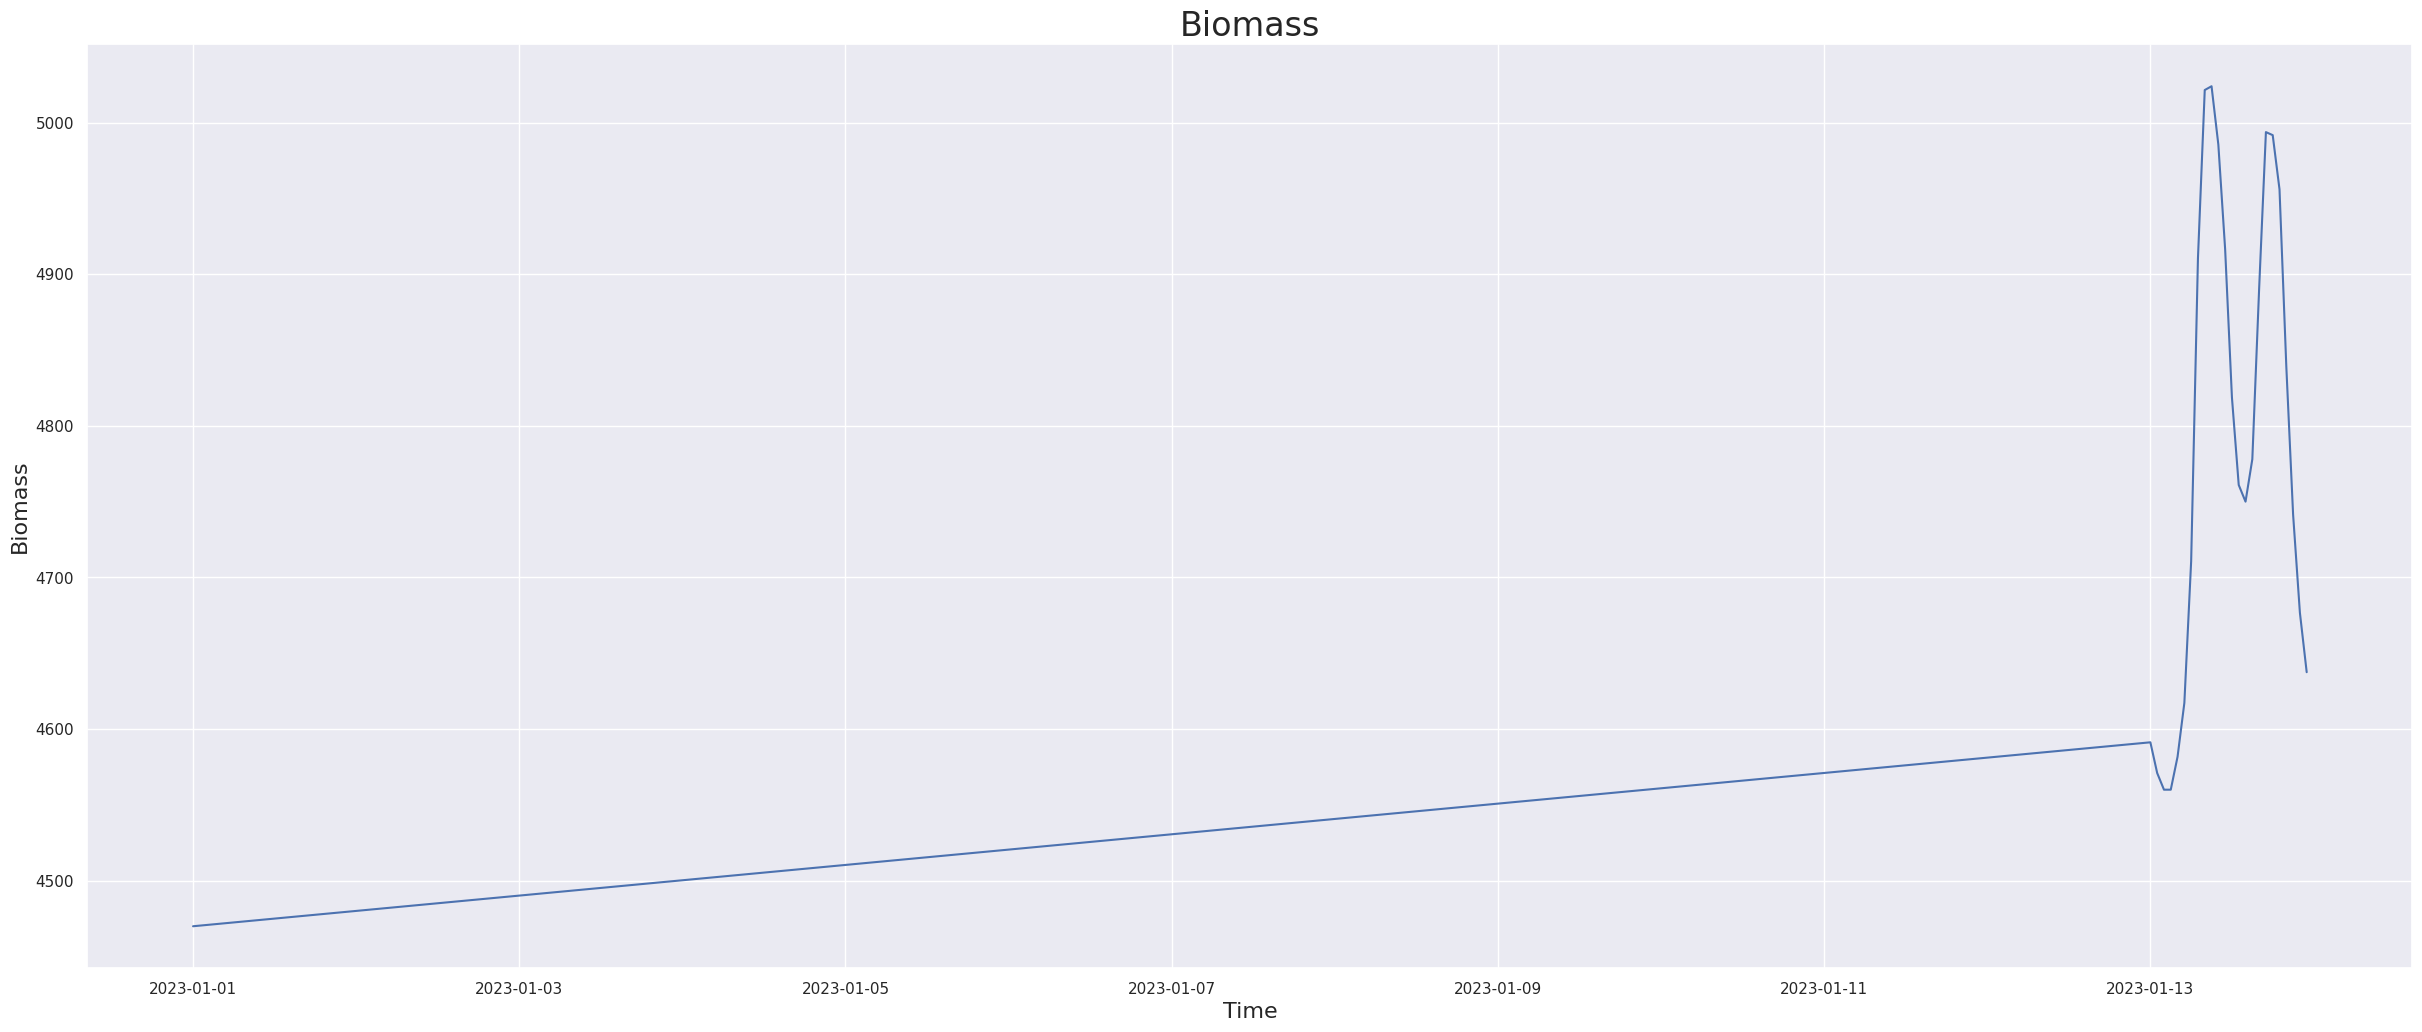

In [28]:
# Now lets have a look at the Biomass data
biomass_col = ('Biomass', 'Actual Aggregated')
ax = plot_series(df=df_energy, column=biomass_col, ylabel='Biomass',
                 title='Biomass', end=24*13)
plt.show()

In [29]:
# Fill null values with the previous value
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [30]:
df_energy.isna().sum()

Actual Load                                             0
(Biomass, Actual Aggregated)                            0
(Fossil Brown coal/Lignite, Actual Aggregated)          0
(Fossil Gas, Actual Aggregated)                         0
(Fossil Hard coal, Actual Aggregated)                   0
(Fossil Oil, Actual Aggregated)                         0
(Geothermal, Actual Aggregated)                         0
(Hydro Pumped Storage, Actual Aggregated)               0
(Hydro Pumped Storage, Actual Consumption)              0
(Hydro Run-of-river and poundage, Actual Aggregated)    0
(Hydro Water Reservoir, Actual Aggregated)              0
(Nuclear, Actual Aggregated)                            0
(Other, Actual Aggregated)                              0
(Other renewable, Actual Aggregated)                    0
(Solar, Actual Aggregated)                              0
(Waste, Actual Aggregated)                              0
(Wind Offshore, Actual Aggregated)                      0
(Wind Onshore,

It look like df_energy has been cleaned successfully and is ready for further use as input into our model.

### Weather Dataset

In [31]:
df_weather_all = pd.concat([df_dict['weather_data']], axis=1)
start_date = '2023-01-01'
df_weather = df_weather_all[df_weather_all.index >= start_date]
df_weather = df_weather[df_weather.index <= '2023-06-01']

In [32]:
df_weather.tail(24)

air_temperature  relative_humidity  \
2023-05-31 01:00:00+02:00             10.4               88.0   
2023-05-31 02:00:00+02:00              9.9               92.0   
2023-05-31 03:00:00+02:00              8.8               94.0   
2023-05-31 04:00:00+02:00              7.8               95.0   
2023-05-31 05:00:00+02:00              9.6               86.0   
2023-05-31 06:00:00+02:00             13.8               75.0   
2023-05-31 07:00:00+02:00             16.4               63.0   
2023-05-31 08:00:00+02:00             19.8               46.0   
2023-05-31 09:00:00+02:00             21.5               36.0   
2023-05-31 10:00:00+02:00             23.0               33.0   
2023-05-31 11:00:00+02:00             23.3               30.0   
2023-05-31 12:00:00+02:00             24.3               31.0   
2023-05-31 13:00:00+02:00             25.3               28.0   
2023-05-31 14:00:00+02:00             25.8               27.0   
2023-05-31 15:00:00+02:00             26.1               28.0   
2023-05-31 16:00:00+02:00             25.2               33.0   
2023-05-31 17:00:00+02:00             24.4               38.0   
2023-05-31 18:00:00+02:00             22.6               43.0   
2023-05-31 19:00:00+02:00             21.8               44.0   
2023-05-31 20:00:00+02:00             20.0               51.0   
2023-05-31 21:00:00+02:00             18.2               58.0   
2023-05-31 22:00:00+02:00             18.4               55.0   
2023-05-31 23:00:00+02:00             17.4               57.0   
2023-06-01 00:00:00+02:00             15.9               62.0   

                           cloudiness_total_cover  sun_duration  visibility  \
2023-05-31 01:00:00+02:00                     1.0           0.0     31530.0   
2023-05-31 02:00:00+02:00                     0.0           0.0     27520.0   
2023-05-31 03:00:00+02:00                     0.0           0.0     17980.0   
2023-05-31 04:00:00+02:00                     0.0           0.0     13880.0   
2023-05-31 05:00:00+02:00                     3.0          50.0     27150.0   
2023-05-31 06:00:00+02:00                     2.0          60.0     49610.0   
2023-05-31 07:00:00+02:00                     4.0          60.0     36670.0   
2023-05-31 08:00:00+02:00                     0.0          60.0     53650.0   
2023-05-31 09:00:00+02:00                     0.0          60.0     50210.0   
2023-05-31 10:00:00+02:00                     0.0          60.0     58490.0   
2023-05-31 11:00:00+02:00                     0.0          60.0     41810.0   
2023-05-31 12:00:00+02:00                     0.0          60.0     75000.0   
2023-05-31 13:00:00+02:00                     0.0          60.0     55840.0   
2023-05-31 14:00:00+02:00                     0.0          60.0     46770.0   
2023-05-31 15:00:00+02:00                     3.0          60.0     70440.0   
2023-05-31 16:00:00+02:00                     7.0          60.0     74260.0   
2023-05-31 17:00:00+02:00                     8.0          60.0     42290.0   
2023-05-31 18:00:00+02:00                     8.0          54.0     65640.0   
2023-05-31 19:00:00+02:00                     8.0          55.0     63440.0   
2023-05-31 20:00:00+02:00                     8.0          19.0     57790.0   
2023-05-31 21:00:00+02:00                     8.0           0.0     58330.0   
2023-05-31 22:00:00+02:00                     6.0           0.0     61380.0   
2023-05-31 23:00:00+02:00                     8.0           0.0     64120.0   
2023-06-01 00:00:00+02:00                     6.0           0.0     54010.0   

                           wind_speed  wind_direction  pressure_msl    city  
2023-05-31 01:00:00+02:00         1.0           120.0        1024.7  munich  
2023-05-31 02:00:00+02:00         0.9           200.0        1024.8  munich  
2023-05-31 03:00:00+02:00         0.7           160.0        1024.8  munich  
2023-05-31 04:00:00+02:00         1.1           110.0        1024.9  munich  
2023-05-31 05:00:00+02:00         0

In [33]:
df_weather.describe().round(2)

air_temperature  relative_humidity  cloudiness_total_cover  \
count         10875.00           10875.00                10875.00   
mean              6.06              79.00                    6.26   
std               6.03              17.37                    2.86   
min              -8.50              20.00                    0.00   
25%               1.50              68.00                    7.00   
50%               5.90              81.00                    8.00   
75%              10.10              95.00                    8.00   
max              26.10             100.00                    8.00   

       sun_duration  visibility  wind_speed  wind_direction  pressure_msl  
count       9813.00    10815.00    10874.00        10874.00       7250.00  
mean          10.58    34445.03        4.92          196.44       1018.02  
std           20.44    23855.33        2.61           96.70         10.88  
min            0.00       40.00        0.30            0.00        978.30  
25%            0.00    11330.00        2.90          120.00       1011.70  
50%            0.00    35750.00        4.60          210.00       1018.70  
75%            6.00    54250.00        6.50          270.00       1024.90  
max           60.00    75000.00       17.30          360.00       1043.80

As you can see we have some missing values for some columns. Let's see how we can handle those missin values

In [34]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10875 entries, 2023-01-01 00:00:00+01:00 to 2023-06-01 00:00:00+02:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   air_temperature         10875 non-null  float64
 1   relative_humidity       10875 non-null  float64
 2   cloudiness_total_cover  10875 non-null  float64
 3   sun_duration            9813 non-null   float64
 4   visibility              10815 non-null  float64
 5   wind_speed              10874 non-null  float64
 6   wind_direction          10874 non-null  float64
 7   pressure_msl            7250 non-null   float64
 8   city                    10875 non-null  object 
dtypes: float64(8), object(1)
memory usage: 849.6+ KB


We have to split the df_weather dataset into 3 datasets, one for each different city (Berlin, Frankfurt and Munich). But first, let's see the average values for each column, grouped by each city

In [35]:
# Display average weather features grouped by each city

mean_weather_by_city = df_weather.groupby('city').mean()
mean_weather_by_city

air_temperature  relative_humidity  cloudiness_total_cover  \
city                                                                    
berlin            6.850510          75.145655                 6.21931   
frankfurt         3.096662          87.639724                 6.38069   
munich            8.240855          74.219862                 6.17600   

           sun_duration    visibility  wind_speed  wind_direction  \
city                                                                
berlin        11.431672  38976.504828    4.385903      200.965517   
frankfurt      9.303883  25088.665545    6.778207      197.991724   
munich        11.014063  39122.784985    3.606981      190.372517   

           pressure_msl  
city                     
berlin      1017.829241  
frankfurt           NaN  
munich      1018.209434

In [36]:
df_weather[df_weather['city'] == 'frankfurt'].isna().sum()

air_temperature              0
relative_humidity            0
cloudiness_total_cover       0
sun_duration               354
visibility                  58
wind_speed                   0
wind_direction               0
pressure_msl              3625
city                         0
dtype: int64

In [37]:
df_weather[df_weather['city'] == 'berlin'].isna().sum()

air_temperature             0
relative_humidity           0
cloudiness_total_cover      0
sun_duration              354
visibility                  0
wind_speed                  0
wind_direction              0
pressure_msl                0
city                        0
dtype: int64

In [38]:
df_weather[df_weather['city'] == 'munich'].isna().sum()

air_temperature             0
relative_humidity           0
cloudiness_total_cover      0
sun_duration              354
visibility                  2
wind_speed                  1
wind_direction              1
pressure_msl                0
city                        0
dtype: int64

Since the pressure msl values are NaN for frankfurt we can drop that future from the weather data

In [39]:
# drop pressure featuyre
df_weather.drop('pressure_msl', axis=1, inplace=True)

In [40]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 1124 missing values or NaNs in df_weather.
There are 1 duplicate rows in df_weather based on all columns.


In [41]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city'].unique()
grouped_weather = df_weather.groupby('city')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 3624 observations in df_energy.
There are 3625 observations in df_weather about city: berlin.
There are 3625 observations in df_weather about city: frankfurt.
There are 3625 observations in df_weather about city: munich.


As we can see df_energy and df_weather can be merged but we need to handle the missing values first

In [42]:
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [43]:
missing_statistics(df_weather)

COLUMN NAME  MISSING VALUES  TOTAL ROWS  % MISSING
0         air_temperature               0       10875       0.00
1       relative_humidity               0       10875       0.00
2  cloudiness_total_cover               0       10875       0.00
3            sun_duration            1062       10875       9.77
4              visibility              60       10875       0.55
5              wind_speed               1       10875       0.01
6          wind_direction               1       10875       0.01
7                    city               0       10875       0.00

This dataset consists of hourly weather information. So we are going to fill missing values based on below new dat features

In [44]:
df_weather["datetime"] = pd.to_datetime(df_weather.index)
df_weather["day"] = df_weather["datetime"].dt.day
df_weather["week"] = df_weather["datetime"].dt.isocalendar().week
df_weather["month"] = df_weather["datetime"].dt.month
df_weather["hour"] = df_weather["datetime"].dt.hour

In [45]:
df_weather

air_temperature  relative_humidity  \
2023-01-01 00:00:00+01:00             16.1               56.0   
2023-01-01 01:00:00+01:00             16.1               56.0   
2023-01-01 02:00:00+01:00             15.4               57.0   
2023-01-01 03:00:00+01:00             15.1               56.0   
2023-01-01 04:00:00+01:00             15.4               53.0   
...                                    ...                ...   
2023-05-31 20:00:00+02:00             20.0               51.0   
2023-05-31 21:00:00+02:00             18.2               58.0   
2023-05-31 22:00:00+02:00             18.4               55.0   
2023-05-31 23:00:00+02:00             17.4               57.0   
2023-06-01 00:00:00+02:00             15.9               62.0   

                           cloudiness_total_cover  sun_duration  visibility  \
2023-01-01 00:00:00+01:00                     8.0           NaN     16340.0   
2023-01-01 01:00:00+01:00                     8.0           NaN     59470.0   
2023-01-01 02:00:00+01:00                     8.0           NaN     53430.0   
2023-01-01 03:00:00+01:00                     8.0           0.0     61190.0   
2023-01-01 04:00:00+01:00                     8.0           0.0     72030.0   
...                                           ...           ...         ...   
2023-05-31 20:00:00+02:00                     8.0          19.0     57790.0   
2023-05-31 21:00:00+02:00                     8.0           0.0     58330.0   
2023-05-31 22:00:00+02:00                     6.0           0.0     61380.0   
2023-05-31 23:00:00+02:00                     8.0           0.0     64120.0   
2023-06-01 00:00:00+02:00                     6.0           0.0     54010.0   

                           wind_speed  wind_direction    city  \
2023-01-01 00:00:00+01:00         6.0           200.0  berlin   
2023-01-01 01:00:00+01:00         6.5           210.0  berlin   
2023-01-01 02:00:00+01:00         6.2           210.0  berlin   
2023-01-01 03:00:00+01:00         6.1           190.0  berlin   
2023-01-01 04:00:00+01:00         6.4           190.0  berlin   
...                               ...             ...     ...   
2023-05-31 20:00:00+02:00         4.4            30.0  munich   
2023-05-31 21:00:00+02:00         3.9            30.0  munich   
2023-05-31 22:00:00+02:00         4.6            50.0  munich   
2023-05-31 23:00:00+02:00         3.8            70.0  munich   
2023-06-01 00:00:00+02:00         2.3           100.0  munich   

                                           datetime  day  week  month  hour  
2023-01-01 00:00:00+01:00 2023-01-01 00:00:00+01:00    1    52      1     0  
2023-01-01 01:00:00+01:00 2023-01-01 01:00:00+01:00    1    52      1     1  
2023-01-01 02:00:00+01:00 2023-01-01 02:00:00+01:00    1    52      1     2  
2023-01-01 03:00:00+01:00 2023-01-01 03:00:00+01:00    1    52      1     3  
2023-01-01 04:00:00+01:00 2023-01-01 04:00:00+01:00    1    52      1     4  
...                                             ...  ...   ...    ...   ...  
2023-05-31 20:00:00+02:00 2023-05-31 20:00:00+02:00   31    22      5    20  
2023-05-31 21:00:00+02:00 2023-05-31 21:00:00+02:00   31    22      5    21  
2023-05-31 22:00:00+02:00 2023-05-31 22:00:00+02:00   31    22      5    22  
2023-05-31 23:00:00+02:00 2023-05-31 23:00:00+02:00   31    22      5    23  
2023-06-01 00:00:00+02:00 2023-06-01 00:00:00+02:00    1    22      6     0  

[10875 rows x 13 columns]

In [46]:
weather_df = df_weather.copy()

In [47]:
# Reset Index for Fast Update
weather_df = weather_df.set_index(['city','day','month'])

In [48]:
weather_df

air_temperature  relative_humidity  cloudiness_total_cover  \
city   day month                                                               
berlin 1   1                 16.1               56.0                     8.0   
           1                 16.1               56.0                     8.0   
           1                 15.4               57.0                     8.0   
           1                 15.1               56.0                     8.0   
           1                 15.4               53.0                     8.0   
...                           ...                ...                     ...   
munich 31  5                 20.0               51.0                     8.0   
           5                 18.2               58.0                     8.0   
           5                 18.4               55.0                     6.0   
           5                 17.4               57.0                     8.0   
       1   6                 15.9               62.0                     6.0   

                  sun_duration  visibility  wind_speed  wind_direction  \
city   day month                                                         
berlin 1   1               NaN     16340.0         6.0           200.0   
           1               NaN     59470.0         6.5           210.0   
           1               NaN     53430.0         6.2           210.0   
           1               0.0     61190.0         6.1           190.0   
           1               0.0     72030.0         6.4           190.0   
...                        ...         ...         ...             ...   
munich 31  5              19.0     57790.0         4.4            30.0   
           5               0.0     58330.0         3.9            30.0   
           5               0.0     61380.0         4.6            50.0   
           5               0.0     64120.0         3.8            70.0   
       1   6               0.0     54010.0         2.3           100.0   

                                  datetime  week  hour  
city   day month                                        
berlin 1   1     2023-01-01 00:00:00+01:00    52     0  
           1     2023-01-01 01:00:00+01:00    52     1  
           1     2023-01-01 02:00:00+01:00    52     2  
           1     2023-01-01 03:00:00+01:00    52     3  
           1     2023-01-01 04:00:00+01:00    52     4  
...                                    ...   ...   ...  
munich 31  5     2023-05-31 20:00:00+02:00    22    20  
           5     2023-05-31 21:00:00+02:00    22    21  
           5     2023-05-31 22:00:00+02:00    22    22  
           5     2023-05-31 23:00:00+02:00    22    23  
       1   6     2023-06-01 00:00:00+02:00    22     0  

[10875 rows x 10 columns]

#### Fill sun duration
Sun duration in the context of hourly weather data typically refers to the number of minutes in each hourly interval during which the sun was shining. This can be less than 60 minutes for a variety of reasons. For example, if it's partly cloudy, the sun might be obscured for part of the hour. At sunrise and sunset, the sun might only be up for part of the hour. In the night hours, sun duration would be zero.

fill missing sun duration with based on hourly information forward and backward fill could be a good idea

In [49]:
# forwad fill sun_duration
weather_df['sun_duration'] = weather_df.groupby(['city','hour'])['sun_duration'].ffill().bfill()

#### Fill Visibility
In meteorology, visibility refers to the distance at which an object or light can be clearly discerned. It is reported within weather observations and forecasts in the context of the distance a person can see in the prevailing atmospheric conditions. Visibility can be affected by a number of factors including fog, mist, precipitation (like rain, snow, or hail), dust, smoke, and other particles in the air.

fill missing visibility with mean of hour of the day.

In [50]:
visibility_filler = pd.DataFrame(weather_df.groupby(['city','hour', 'day'])['visibility'].mean(),columns=["visibility"])
weather_df.update(visibility_filler,overwrite=False)
visibility_filler = pd.DataFrame(weather_df.groupby(['city','day', 'week'])['visibility'].mean(),columns=["visibility"])
weather_df.update(visibility_filler,overwrite=False)

#### Fill Wind Speed and Wind Direction

In [51]:
wind_speed_filler = pd.DataFrame(weather_df.groupby(['city','hour', 'day'])['wind_speed'].mean(),columns=["wind_speed"])
weather_df.update(wind_speed_filler,overwrite=False)
weather_df['wind_speed'] = weather_df.groupby(['city','hour'])['wind_speed'].ffill().bfill()

wind_direction_filler = pd.DataFrame(weather_df.groupby(['city','hour', 'day'])['wind_speed'].mean(),columns=["wind_direction"])
weather_df.update(wind_direction_filler,overwrite=False)
weather_df['wind_direction'] = weather_df.groupby(['city','hour'])['wind_direction'].ffill().bfill()

#### Remove those extra features

In [52]:
weather_df = weather_df.reset_index()
weather_df = weather_df.drop(['day','week','month', 'hour'],axis=1)

In [53]:
weather_df.set_index('datetime', inplace=True)

In [54]:
df_weather

air_temperature  relative_humidity  \
2023-01-01 00:00:00+01:00             16.1               56.0   
2023-01-01 01:00:00+01:00             16.1               56.0   
2023-01-01 02:00:00+01:00             15.4               57.0   
2023-01-01 03:00:00+01:00             15.1               56.0   
2023-01-01 04:00:00+01:00             15.4               53.0   
...                                    ...                ...   
2023-05-31 20:00:00+02:00             20.0               51.0   
2023-05-31 21:00:00+02:00             18.2               58.0   
2023-05-31 22:00:00+02:00             18.4               55.0   
2023-05-31 23:00:00+02:00             17.4               57.0   
2023-06-01 00:00:00+02:00             15.9               62.0   

                           cloudiness_total_cover  sun_duration  visibility  \
2023-01-01 00:00:00+01:00                     8.0           NaN     16340.0   
2023-01-01 01:00:00+01:00                     8.0           NaN     59470.0   
2023-01-01 02:00:00+01:00                     8.0           NaN     53430.0   
2023-01-01 03:00:00+01:00                     8.0           0.0     61190.0   
2023-01-01 04:00:00+01:00                     8.0           0.0     72030.0   
...                                           ...           ...         ...   
2023-05-31 20:00:00+02:00                     8.0          19.0     57790.0   
2023-05-31 21:00:00+02:00                     8.0           0.0     58330.0   
2023-05-31 22:00:00+02:00                     6.0           0.0     61380.0   
2023-05-31 23:00:00+02:00                     8.0           0.0     64120.0   
2023-06-01 00:00:00+02:00                     6.0           0.0     54010.0   

                           wind_speed  wind_direction    city  \
2023-01-01 00:00:00+01:00         6.0           200.0  berlin   
2023-01-01 01:00:00+01:00         6.5           210.0  berlin   
2023-01-01 02:00:00+01:00         6.2           210.0  berlin   
2023-01-01 03:00:00+01:00         6.1           190.0  berlin   
2023-01-01 04:00:00+01:00         6.4           190.0  berlin   
...                               ...             ...     ...   
2023-05-31 20:00:00+02:00         4.4            30.0  munich   
2023-05-31 21:00:00+02:00         3.9            30.0  munich   
2023-05-31 22:00:00+02:00         4.6            50.0  munich   
2023-05-31 23:00:00+02:00         3.8            70.0  munich   
2023-06-01 00:00:00+02:00         2.3           100.0  munich   

                                           datetime  day  week  month  hour  
2023-01-01 00:00:00+01:00 2023-01-01 00:00:00+01:00    1    52      1     0  
2023-01-01 01:00:00+01:00 2023-01-01 01:00:00+01:00    1    52      1     1  
2023-01-01 02:00:00+01:00 2023-01-01 02:00:00+01:00    1    52      1     2  
2023-01-01 03:00:00+01:00 2023-01-01 03:00:00+01:00    1    52      1     3  
2023-01-01 04:00:00+01:00 2023-01-01 04:00:00+01:00    1    52      1     4  
...                                             ...  ...   ...    ...   ...  
2023-05-31 20:00:00+02:00 2023-05-31 20:00:00+02:00   31    22      5    20  
2023-05-31 21:00:00+02:00 2023-05-31 21:00:00+02:00   31    22      5    21  
2023-05-31 22:00:00+02:00 2023-05-31 22:00:00+02:00   31    22      5    22  
2023-05-31 23:00:00+02:00 2023-05-31 23:00:00+02:00   31    22      5    23  
2023-06-01 00:00:00+02:00 2023-06-01 00:00:00+02:00    1    22      6     0  

[10875 rows x 13 columns]

In [55]:
# Assuming that 'df_weather' is your original DataFrame with missing values
# and 'weather_df' is the DataFrame with which you want to fill missing values

df_weather_filled = df_weather.combine_first(weather_df)
df_weather_filled.drop(['datetime', 'day', 'hour', 'month', 'week'], axis=1, inplace=True)


In [56]:
missing_statistics(df_weather_filled)

COLUMN NAME  MISSING VALUES  TOTAL ROWS  % MISSING
0         air_temperature               0       10875        0.0
1                    city               0       10875        0.0
2  cloudiness_total_cover               0       10875        0.0
3       relative_humidity               0       10875        0.0
4            sun_duration               0       10875        0.0
5              visibility               0       10875        0.0
6          wind_direction               0       10875        0.0
7              wind_speed               0       10875        0.0

#### Handle duplicates

In [57]:
# Display the number of rows in each dataframe again

grouped_weather = df_weather_filled.groupby('city')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 3625 observations in df_weather about city: berlin.
There are 3625 observations in df_weather about city: frankfurt.
There are 3625 observations in df_weather about city: munich.


In [58]:
df_weather_filled.columns

Index(['air_temperature', 'city', 'cloudiness_total_cover',
       'relative_humidity', 'sun_duration', 'visibility', 'wind_direction',
       'wind_speed'],
      dtype='object')

Before proceeding to the next step, i.e. merging df_energy and df_weather, we also want to treat the outliers. We will visualize the outliers in these columns using boxplot, change their values to NaNs and then use a linear interpolation in order to replace their values.

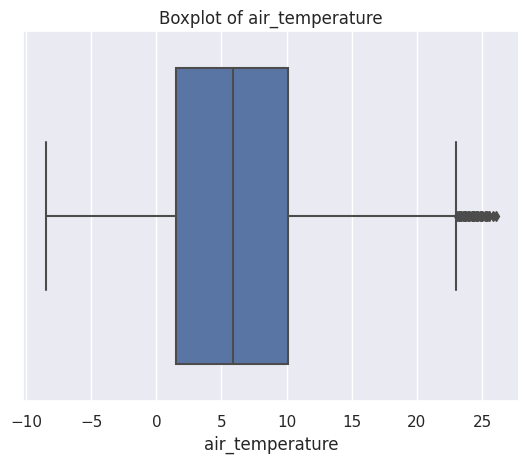

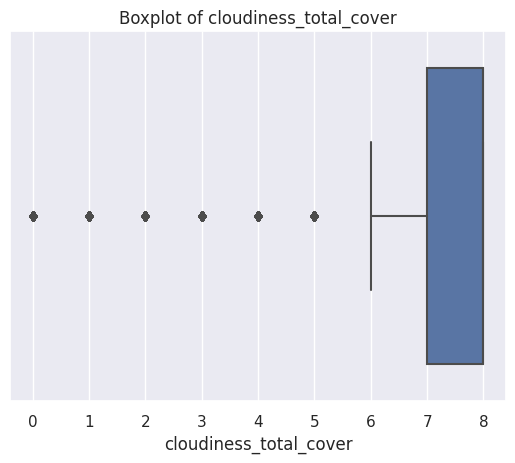

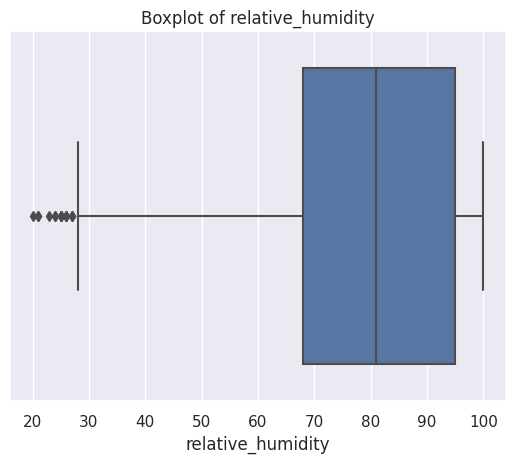

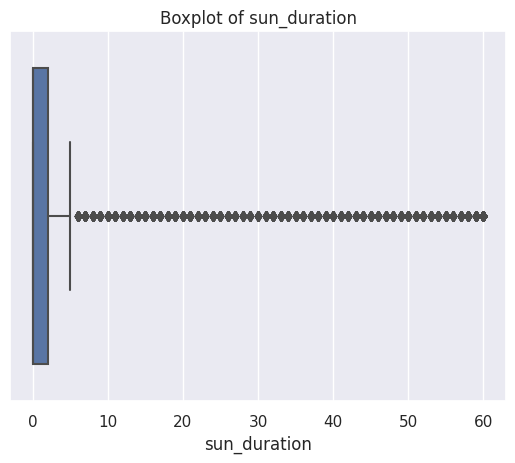

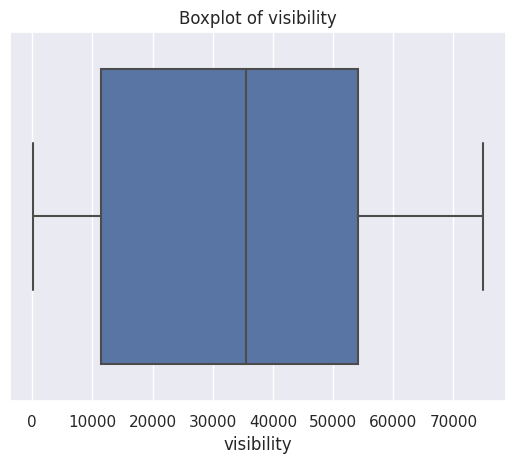

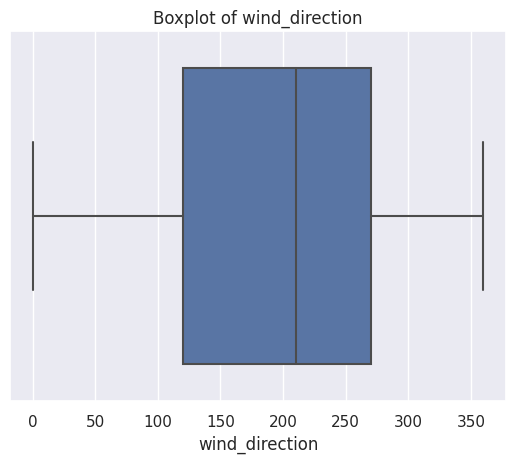

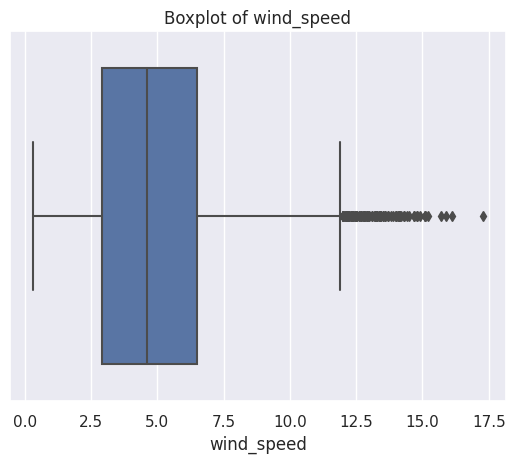

In [59]:
# Iterate over each column in the weather DataFrame
for column in df_weather_filled.columns:
    # Create a boxplot for the current column
    if column == 'city':
        continue
    sns.boxplot(x=weather_df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

Everything looks nice and clean and df_weather is also ready for use as input to our model.

## 1.2. Merge Datasets

In [60]:
# Split the df_weather into 3 dataframes (one for each city)

df_1, df_2, df_3,= [x for _, x in df_weather_filled.groupby('city')]
dfs = [df_1, df_2, df_3]

In [61]:
df_final = df_energy

for df in dfs:
    city = df['city'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, left_index=True, right_index=True, how='outer')
    df_final = df_final.drop('city_{}'.format(city_str), axis=1)
    
df_final.columns

Index([                                           'Actual Load',
                               ('Biomass', 'Actual Aggregated'),
             ('Fossil Brown coal/Lignite', 'Actual Aggregated'),
                            ('Fossil Gas', 'Actual Aggregated'),
                      ('Fossil Hard coal', 'Actual Aggregated'),
                            ('Fossil Oil', 'Actual Aggregated'),
                            ('Geothermal', 'Actual Aggregated'),
                  ('Hydro Pumped Storage', 'Actual Aggregated'),
                 ('Hydro Pumped Storage', 'Actual Consumption'),
       ('Hydro Run-of-river and poundage', 'Actual Aggregated'),
                 ('Hydro Water Reservoir', 'Actual Aggregated'),
                               ('Nuclear', 'Actual Aggregated'),
                                 ('Other', 'Actual Aggregated'),
                       ('Other renewable', 'Actual Aggregated'),
                                 ('Solar', 'Actual Aggregated'),
                         

In [62]:
df_final

Actual Load  (Biomass, Actual Aggregated)  \
2023-01-01 00:00:00+01:00     38931.75                   4469.921280   
2023-01-01 01:00:00+01:00     38314.00                   4470.342561   
2023-01-01 02:00:00+01:00     37470.25                   4470.763841   
2023-01-01 03:00:00+01:00     36497.75                   4471.185121   
2023-01-01 04:00:00+01:00     36065.00                   4471.606401   
...                                ...                           ...   
2023-05-31 20:00:00+02:00     57127.50                   4498.500000   
2023-05-31 21:00:00+02:00     55269.75                   4551.500000   
2023-05-31 22:00:00+02:00     53049.00                   4596.000000   
2023-05-31 23:00:00+02:00     49378.75                   4618.000000   
2023-06-01 00:00:00+02:00     49378.75                   4618.000000   

                           (Fossil Brown coal/Lignite, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                         3859.25   
2023-01-01 01:00:00+01:00                                         3866.50   
2023-01-01 02:00:00+01:00                                         3860.25   
2023-01-01 03:00:00+01:00                                         3864.75   
2023-01-01 04:00:00+01:00                                         3841.00   
...                                                                   ...   
2023-05-31 20:00:00+02:00                                         5894.25   
2023-05-31 21:00:00+02:00                                         5821.75   
2023-05-31 22:00:00+02:00                                         5563.75   
2023-05-31 23:00:00+02:00                                         5148.75   
2023-06-01 00:00:00+02:00                                         5148.75   

                           (Fossil Gas, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                          2469.00   
2023-01-01 01:00:00+01:00                          2292.25   
2023-01-01 02:00:00+01:00                          2240.50   
2023-01-01 03:00:00+01:00                          2243.75   
2023-01-01 04:00:00+01:00                          2254.75   
...                                                    ...   
2023-05-31 20:00:00+02:00                          7014.25   
2023-05-31 21:00:00+02:00                          7072.50   
2023-05-31 22:00:00+02:00                          6869.00   
2023-05-31 23:00:00+02:00                          6386.75   
2023-06-01 00:00:00+02:00                          6386.75   

                           (Fossil Hard coal, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                                2067.50   
2023-01-01 01:00:00+01:00                                2052.00   
2023-01-01 02:00:00+01:00                                2034.25   
2023-01-01 03:00:00+01:00                                2037.00   
2023-01-01 04:00:00+01:00                                2040.25   
...                                                          ...   
2023-05-31 20:00:00+02:00                                1571.25   
2023-05-31 21:00:00+02:00                                1505.75   
2023-05-31 22:00:00+02:00                                1371.50   
2023-05-31 23:00:00+02:00                                1146.00   
2023-06-01 00:00:00+02:00                                1146.00   

                           (Fossil Oil, Actual Aggregated)  \
2023-01-01 00:00:00+01:00                             8.00   
2023-01-01 01:00:00+01:00                             8.00   
2023-01-01 02:00:00+01:00                             8.00   
2023-01-01 03:00:00+01:00                             8.00   
2023-01-01 04:00:00+01:00                             8.00   
...                                                    ...   
2023-05-31 20:00:00+02:00                           375.75   
2023-05-31 21:00:00+02:00                           377.00   
2023-05-31 22:00:00+02:00                           377.00   
2023-05-31 23:00:00+02:00                           376

In [63]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


In [64]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3631 entries, 2023-01-01 00:00:00+01:00 to 2023-06-01 00:00:00+02:00
Data columns (total 40 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Actual Load                                           3631 non-null   float64
 1   (Biomass, Actual Aggregated)                          3631 non-null   float64
 2   (Fossil Brown coal/Lignite, Actual Aggregated)        3631 non-null   float64
 3   (Fossil Gas, Actual Aggregated)                       3631 non-null   float64
 4   (Fossil Hard coal, Actual Aggregated)                 3631 non-null   float64
 5   (Fossil Oil, Actual Aggregated)                       3631 non-null   float64
 6   (Geothermal, Actual Aggregated)                       3631 non-null   float64
 7   (Hydro Pumped Storage, Actual Aggregated)             3631 non-null   float64
 8   (Hydro Pum

In [65]:
# Rename the column for better readability
# Define a function to rename the columns
def rename_column(column):
    # if column is multiindex
    if isinstance(column, tuple):
        return column[0].lower().strip().replace(' ', '_')
    else:
        # lower case and remove trailing whitespace and replace spaces with underscore
        return column.lower().strip().replace(' ', '_')

# Rename the columns of df_final
df_final.columns = df_final.columns.map(rename_column)

# Print the updated columns
df_final.columns


Index(['actual_load', 'biomass', 'fossil_brown_coal/lignite', 'fossil_gas',
       'fossil_hard_coal', 'fossil_oil', 'geothermal', 'hydro_pumped_storage',
       'hydro_pumped_storage', 'hydro_run-of-river_and_poundage',
       'hydro_water_reservoir', 'nuclear', 'other', 'other_renewable', 'solar',
       'waste', 'wind_offshore', 'wind_onshore', 'day_ahead_price',
       'air_temperature_berlin', 'cloudiness_total_cover_berlin',
       'relative_humidity_berlin', 'sun_duration_berlin', 'visibility_berlin',
       'wind_direction_berlin', 'wind_speed_berlin',
       'air_temperature_frankfurt', 'cloudiness_total_cover_frankfurt',
       'relative_humidity_frankfurt', 'sun_duration_frankfurt',
       'visibility_frankfurt', 'wind_direction_frankfurt',
       'wind_speed_frankfurt', 'air_temperature_munich',
       'cloudiness_total_cover_munich', 'relative_humidity_munich',
       'sun_duration_munich', 'visibility_munich', 'wind_direction_munich',
       'wind_speed_munich'],
      dt

# 2. Visualization and Analysis

## 2.1. Useful Visualization

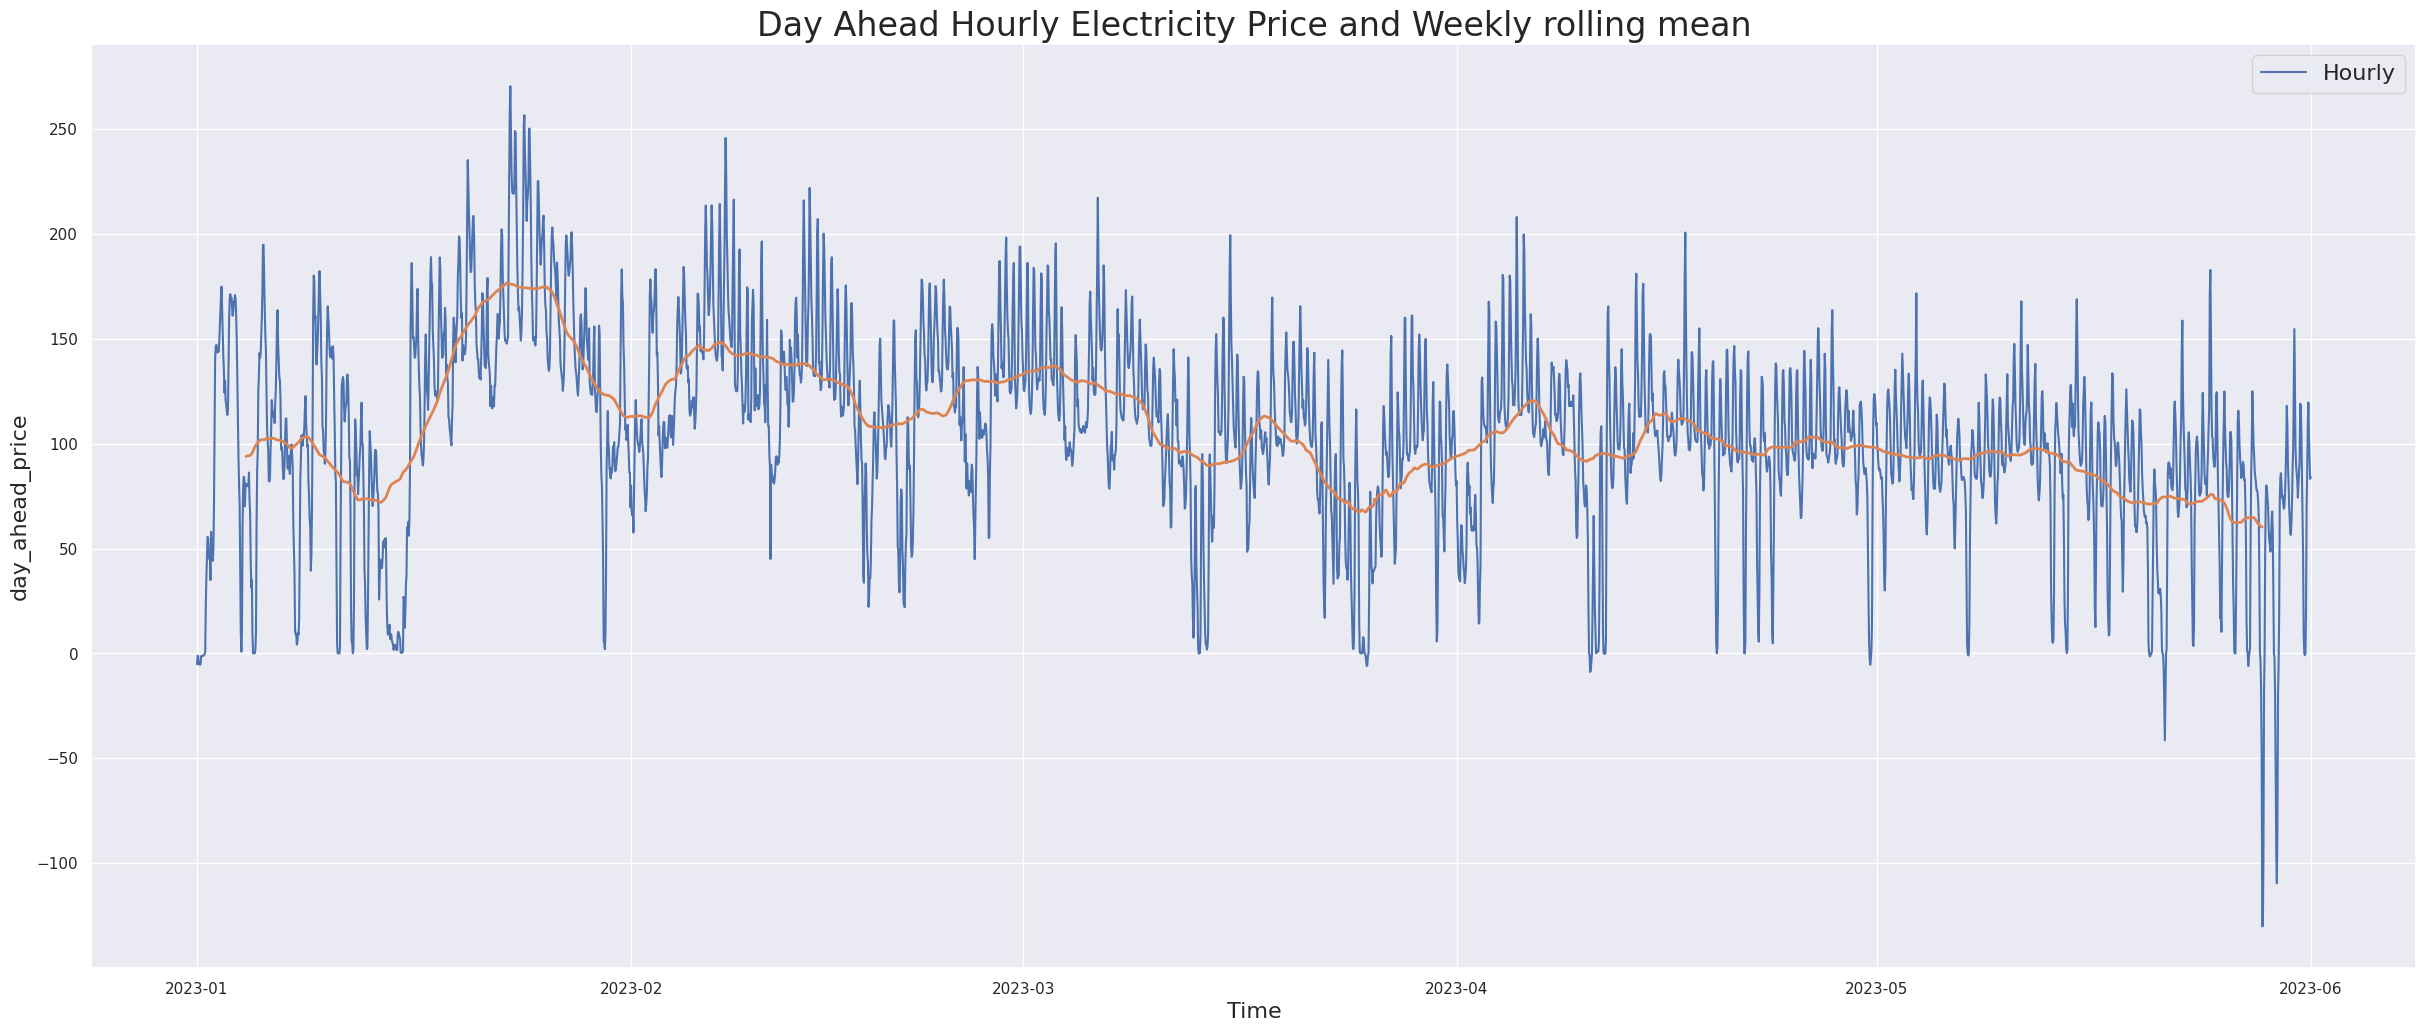

In [66]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['day_ahead_price'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'day_ahead_price', label='Hourly', ylabel='day_ahead_price',
                 title='Day Ahead Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

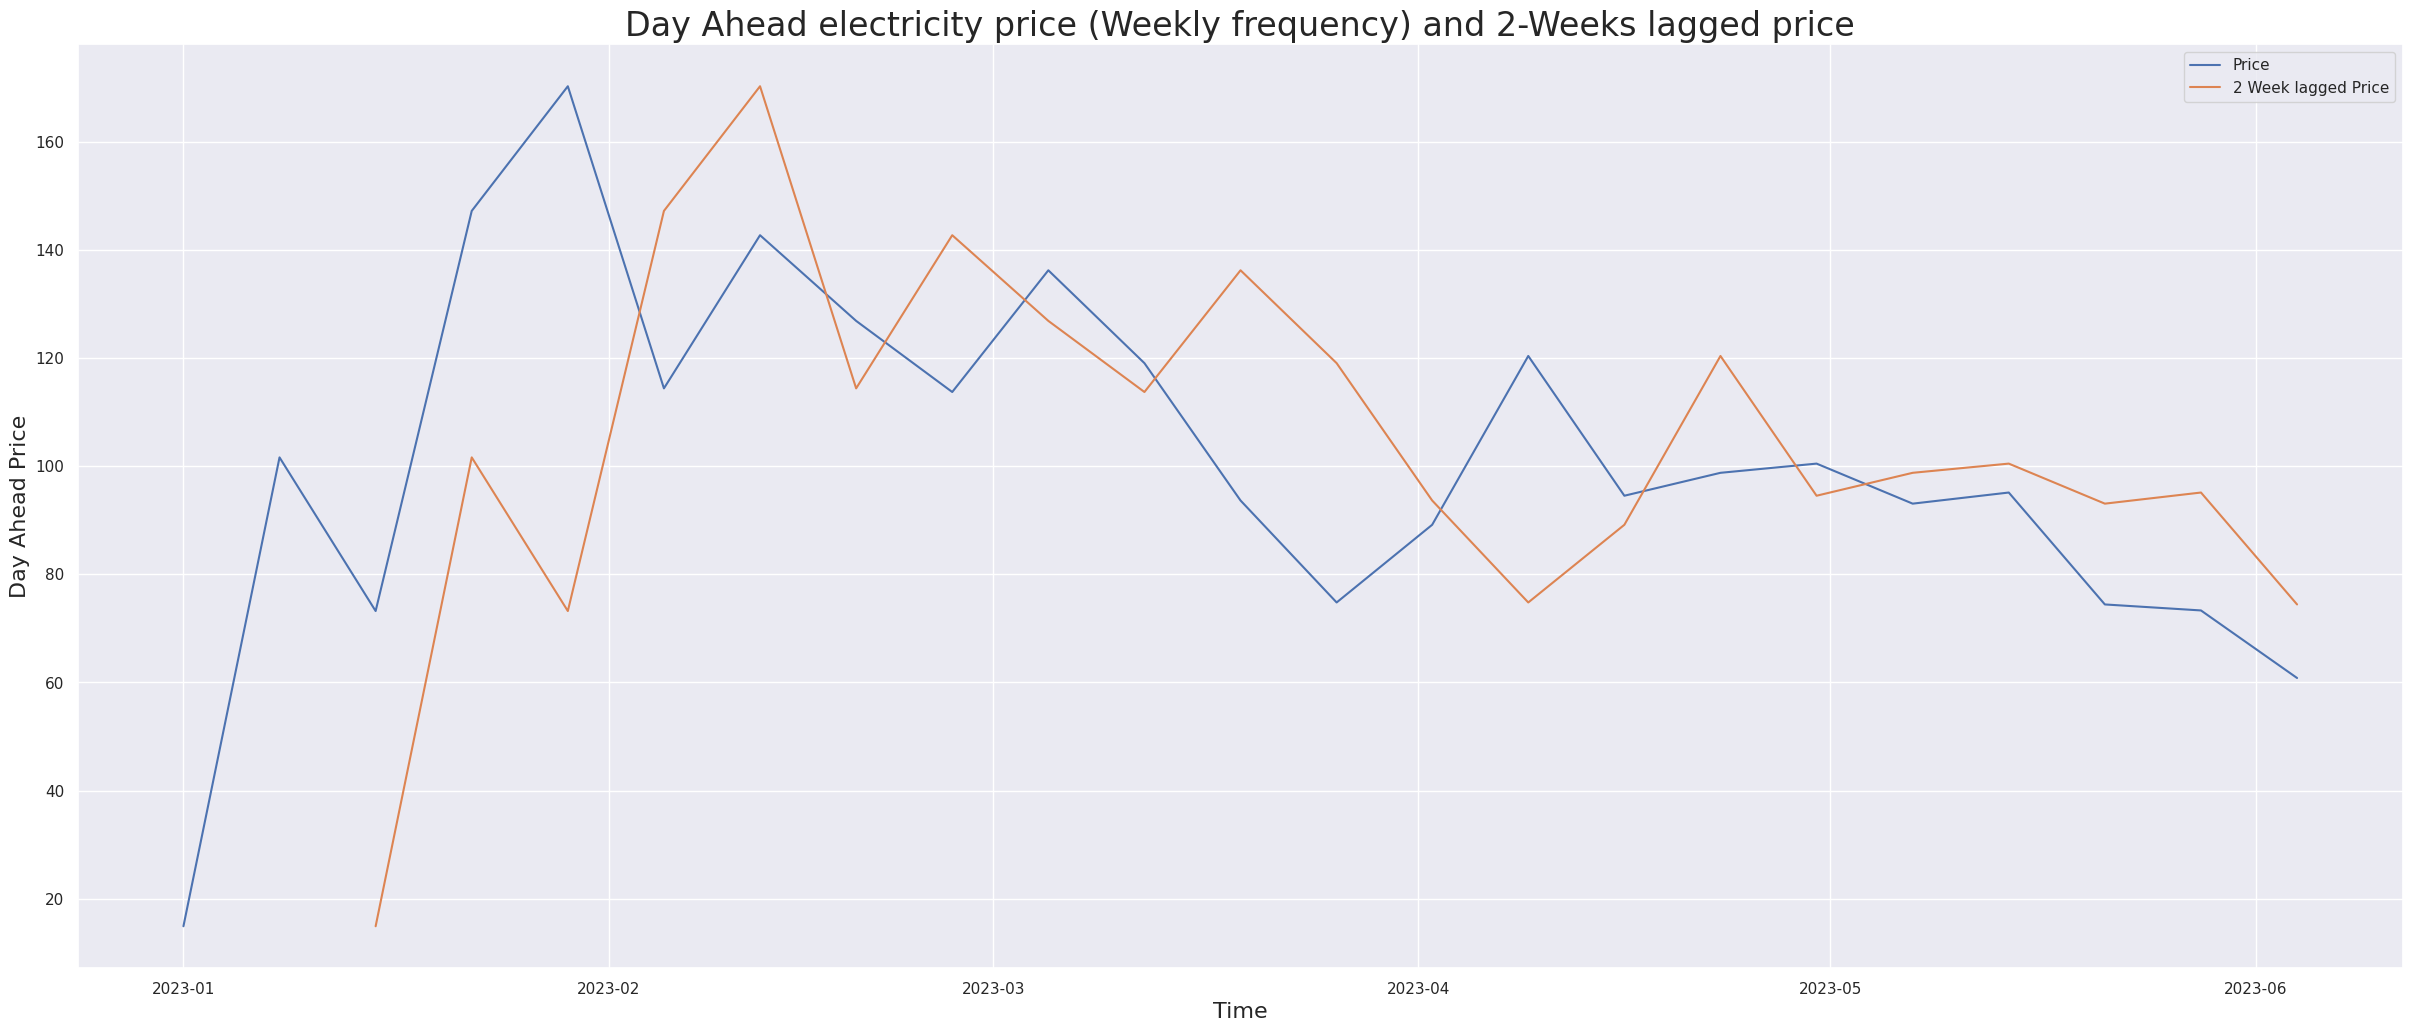

In [67]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

daily_price = df_final['day_ahead_price'].resample('W').mean()
shifted = daily_price.shift(2)
ax = plot_series(series=daily_price, ylabel='Day Ahead Price',
                 title='Day Ahead electricity price (Weekly frequency) and 2-Weeks lagged price')
ax.plot(shifted, label='Hourly')
ax.legend(['Price', '2 Week lagged Price'])
plt.show()

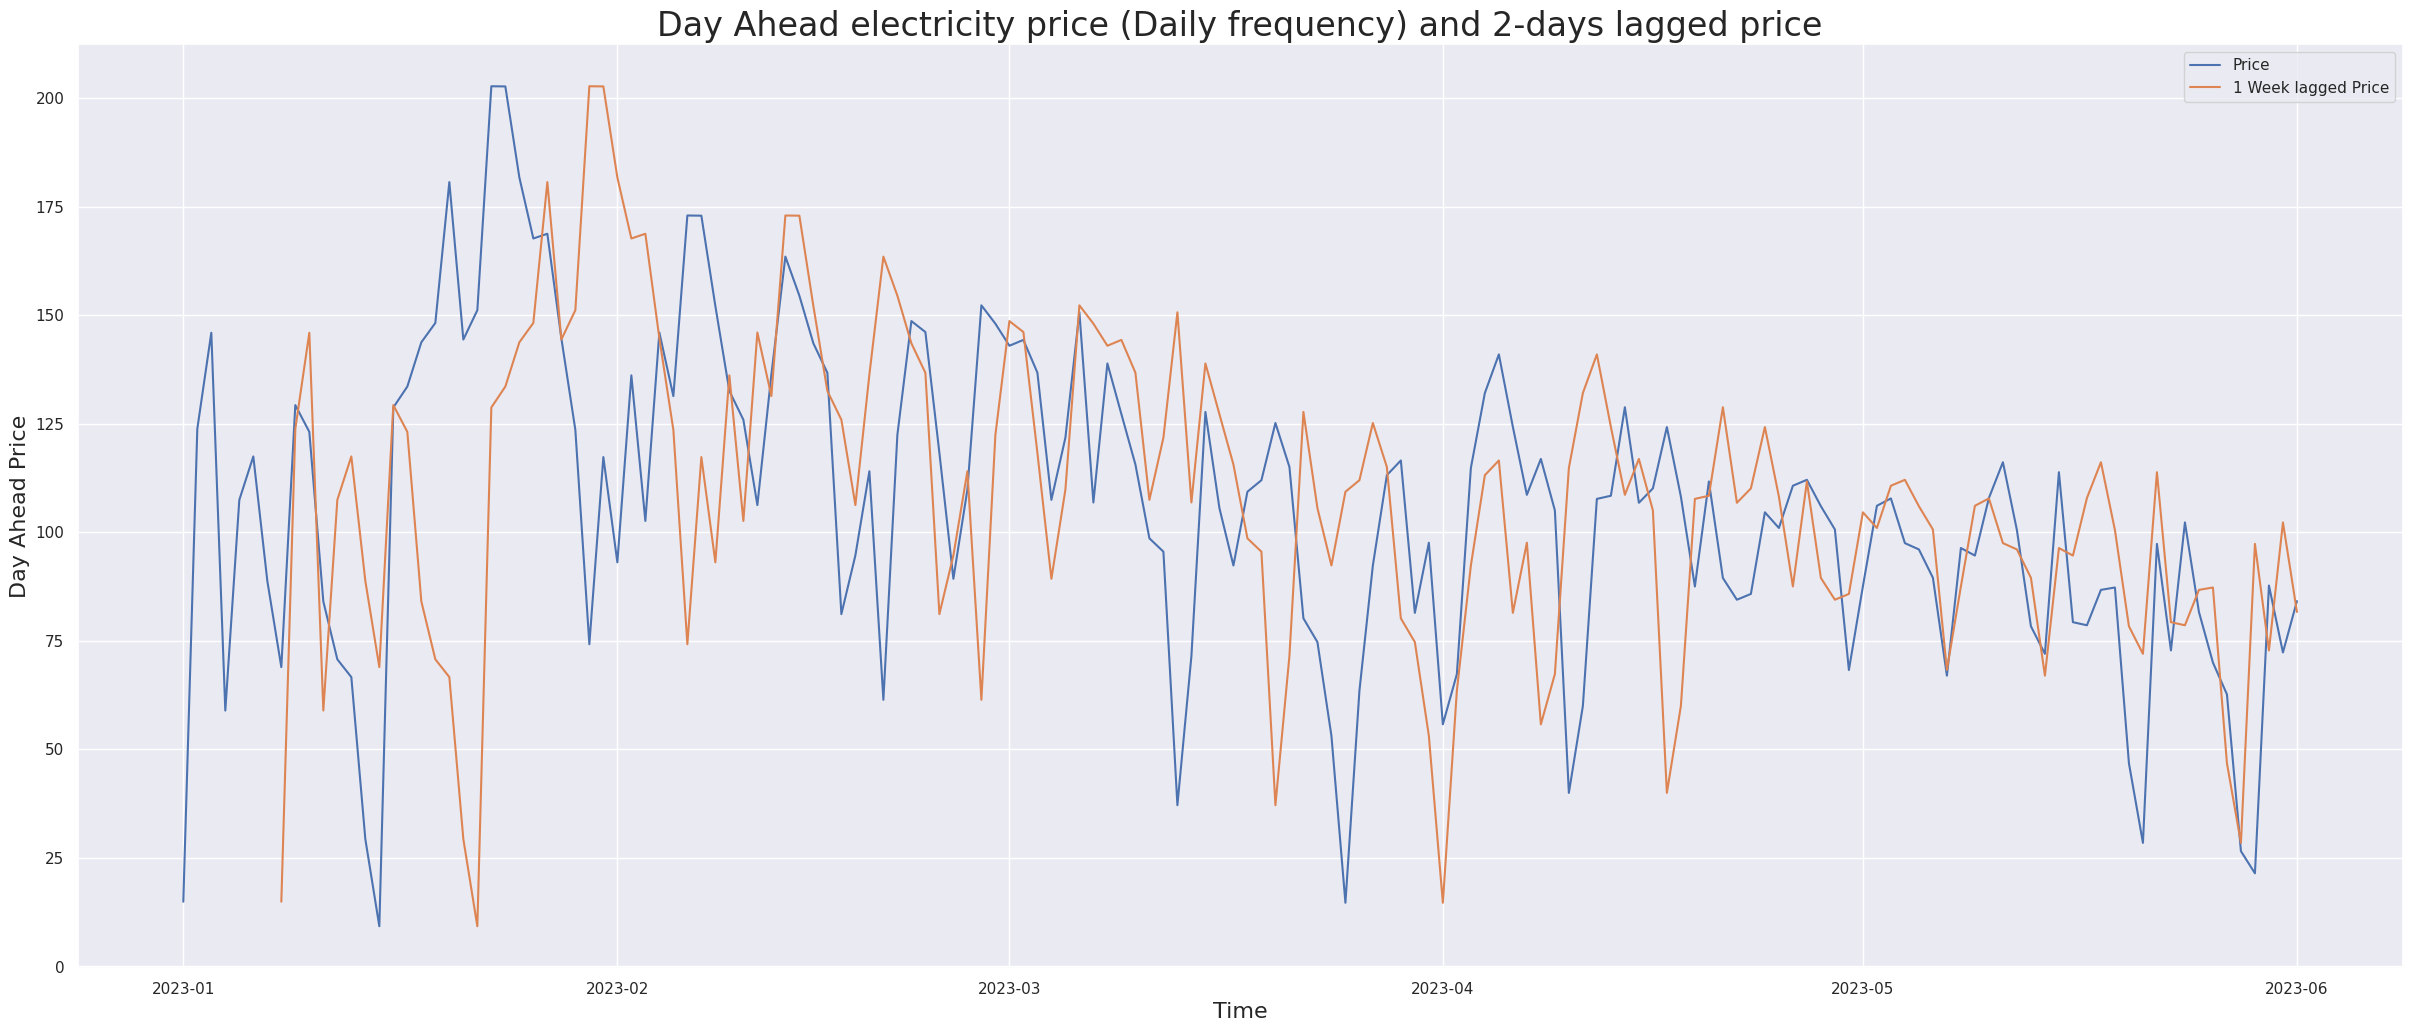

In [68]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

daily_price = df_final['day_ahead_price'].resample('D').mean()
shifted = daily_price.shift(7)
ax = plot_series(series=daily_price, ylabel='Day Ahead Price',
                 title='Day Ahead electricity price (Daily frequency) and 2-days lagged price')
ax.plot(shifted, label='Hourly')
ax.legend(['Price', '1 Week lagged Price'])
plt.show()

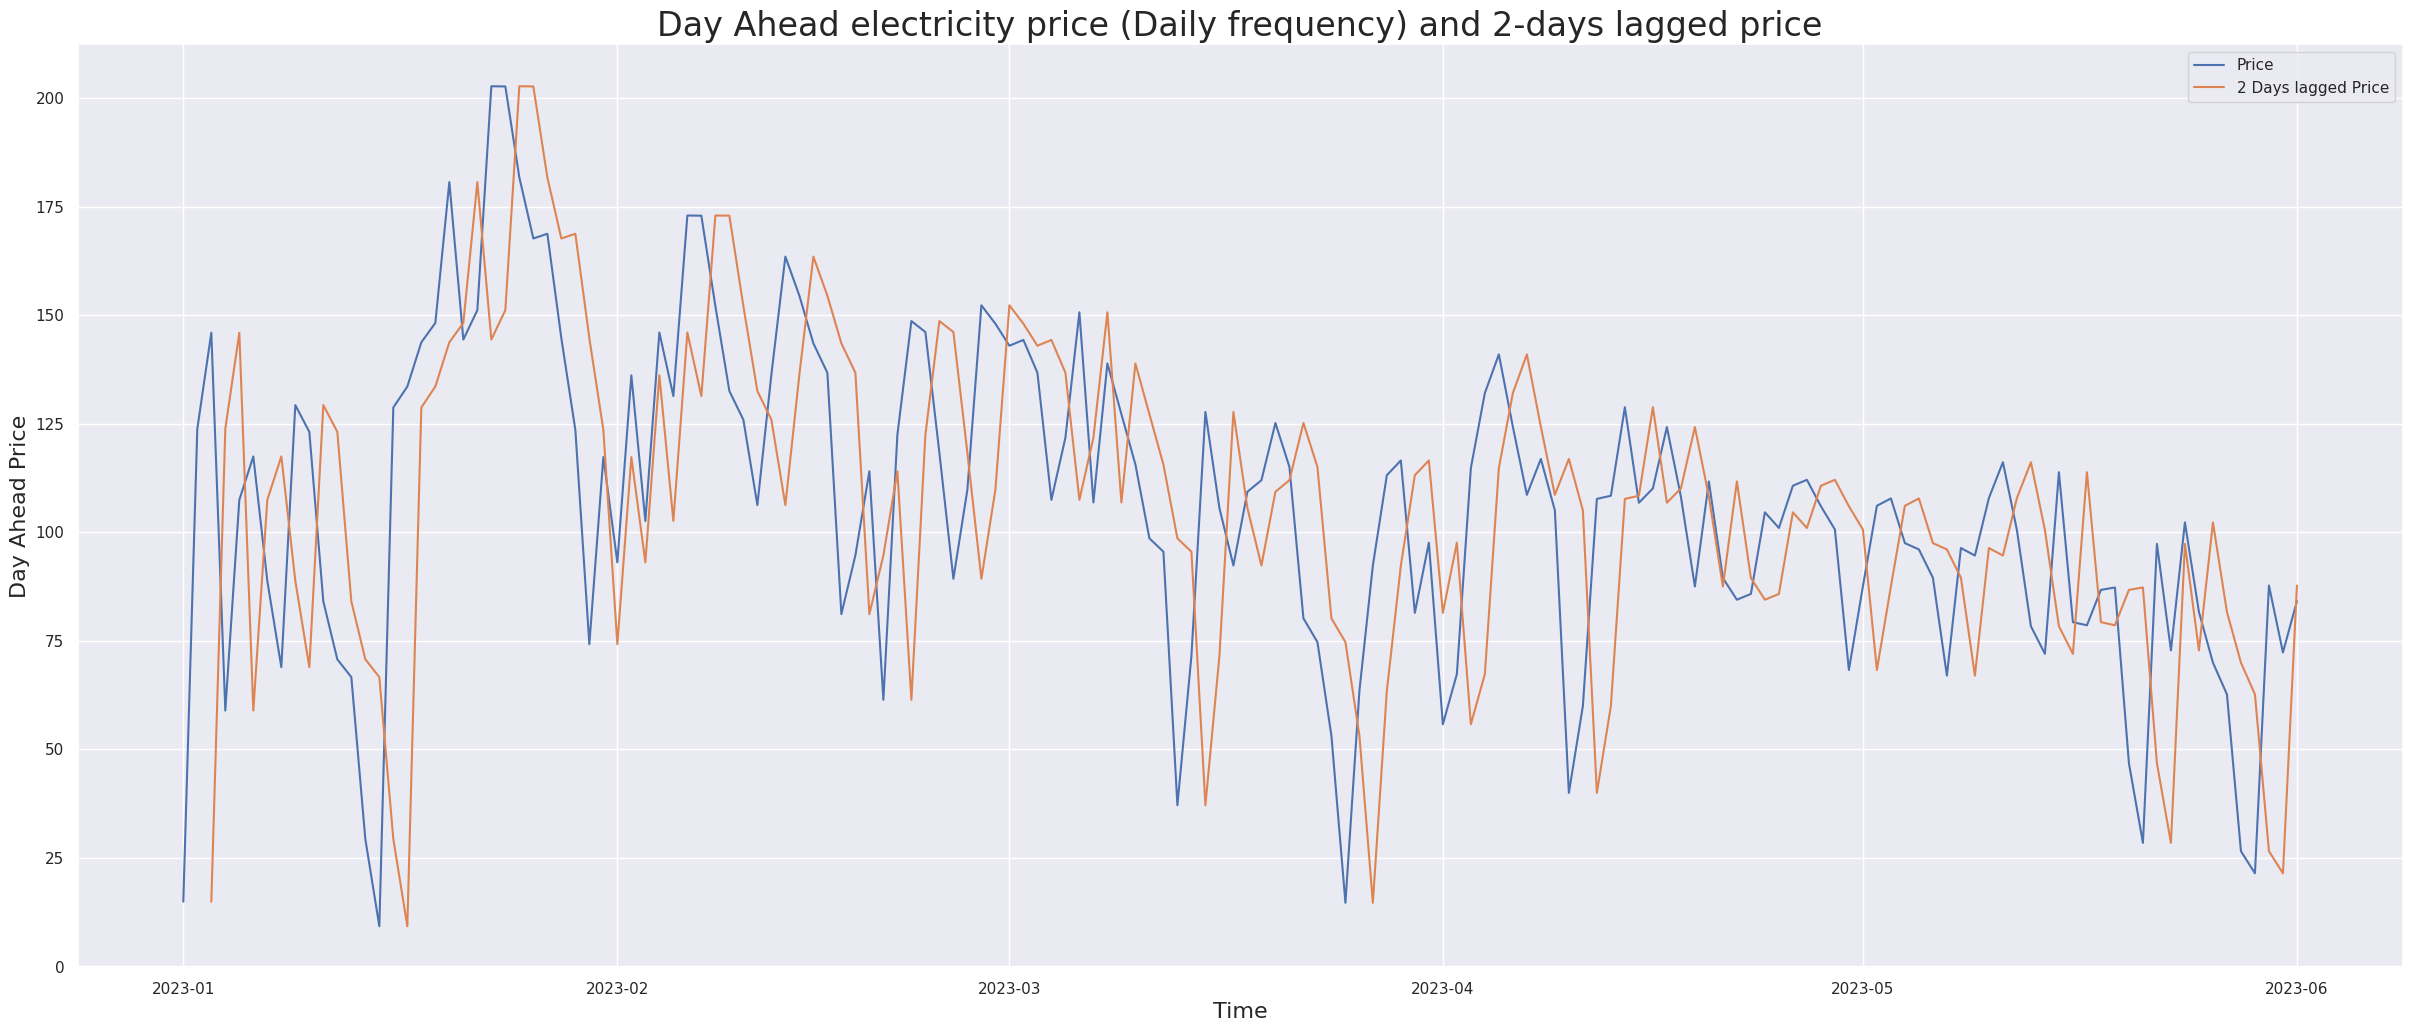

In [69]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

daily_price = df_final['day_ahead_price'].resample('D').mean()
shifted = daily_price.shift(2)
ax = plot_series(series=daily_price, ylabel='Day Ahead Price',
                 title='Day Ahead electricity price (Daily frequency) and 2-days lagged price')
ax.plot(shifted, label='Hourly')
ax.legend(['Price', '2 Days lagged Price'])
plt.show()

When predicting the day ahead prices for day D, only the actual load and generation data for day D-2, will be available, this should be taken into account during pre-processing."

This is referring to the fact that when we want to predict the day ahead prices for a specific day (let's call this "day D"), we can only use actual load and generation data that's from two days before this specific day ("day D-2"). This could be because the data from the day before ("day D-1") hasn't been processed or collected yet, and so it's not available at the time when you need to make the prediction.

As a result, during preprocessing steps, we need to structure our data in such a way that for every record corresponding to "day D", we have corresponding load and generation data from "day D-2". This is why we introduced the concept of "lagging" your data by two days, to ensure this alignment.

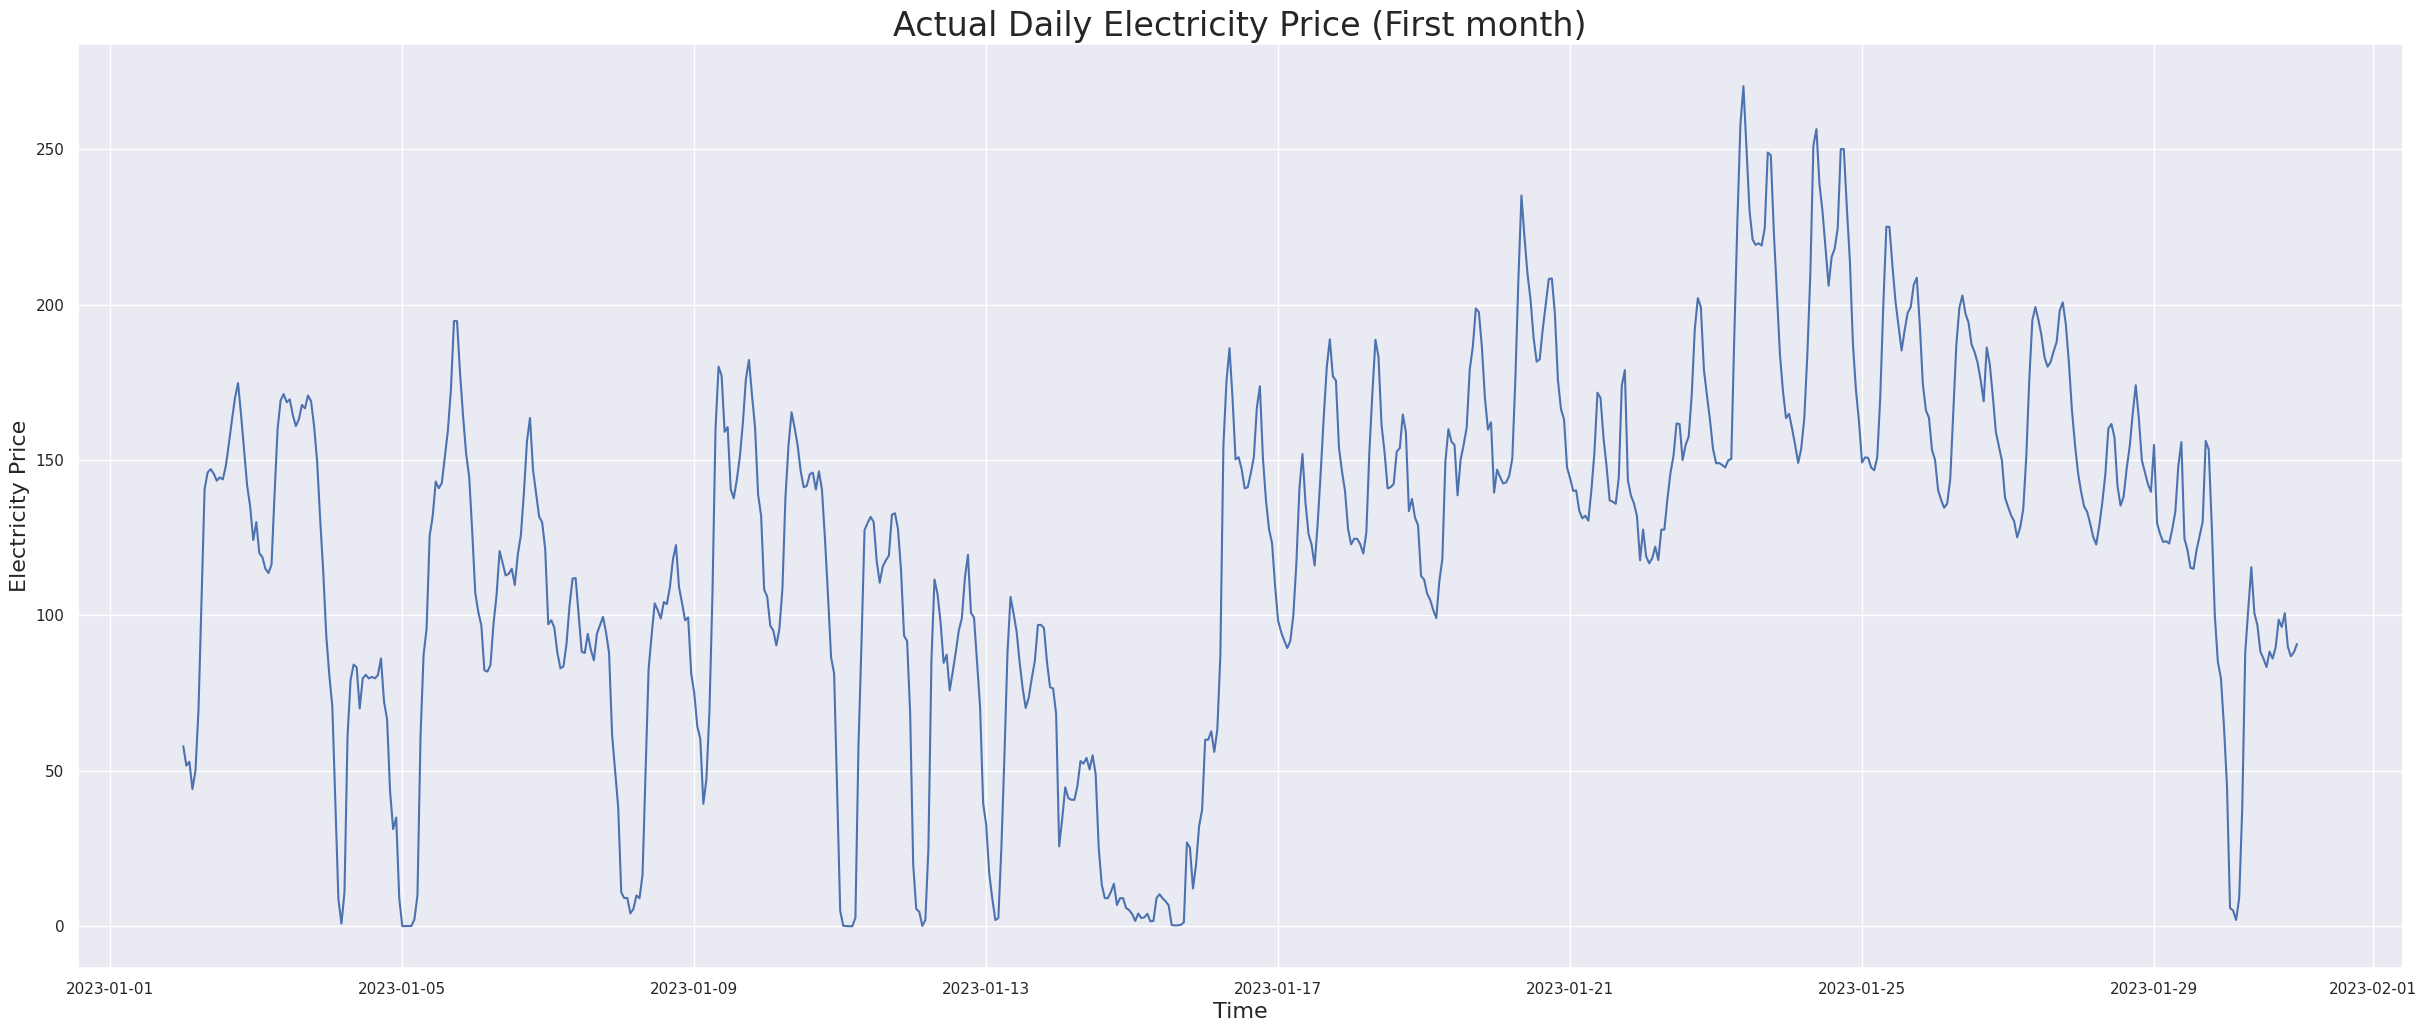

In [70]:
# Resample the 'day_ahead_price' column to daily frequency
daily_prices = df_final['day_ahead_price'].resample('H').mean()

# Select the first month daily prices
first_month = daily_prices[24*1:24*30]

# Plot the daily electricity prices for the first 2 weeks using plot_series
ax = plot_series(series=first_month, ylabel='Electricity Price',
                 title='Actual Daily Electricity Price (First month)')
plt.show()

As we can see there are not much patterns but maybe because of first weeks of the new year (holidays). Lets have a look at the second at the second month

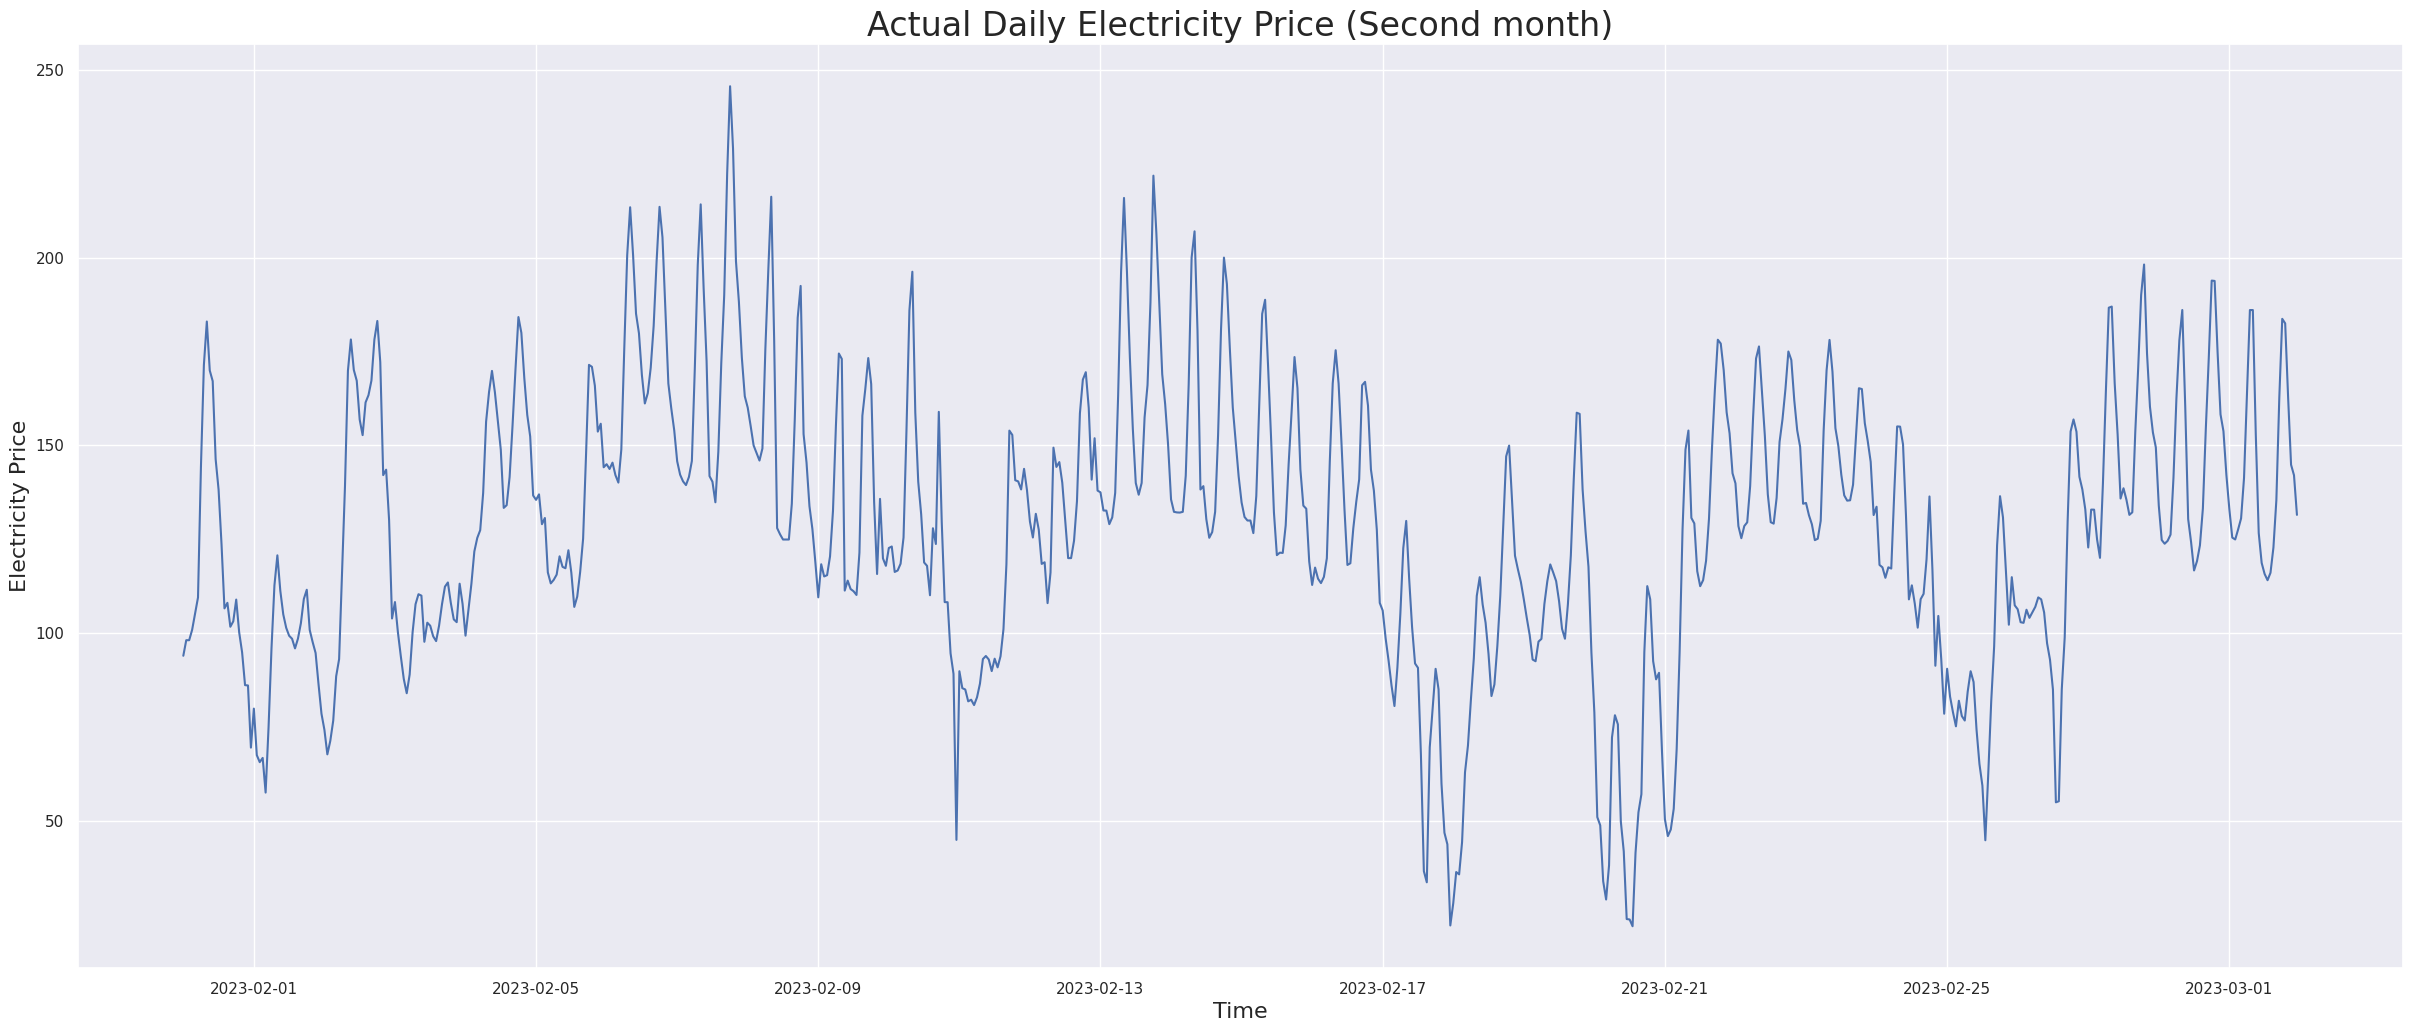

In [71]:
# Resample the 'day_ahead_price' column to daily frequency
daily_prices = df_final['day_ahead_price'].resample('H').mean()

# Select the first month daily prices
first_month = daily_prices[24*30:24*60]

# Plot the daily electricity prices for the first 2 weeks using plot_series
ax = plot_series(series=first_month, ylabel='Electricity Price',
                 title='Actual Daily Electricity Price (Second month)')
plt.show()


BINGO !!!
We can observe that there are many patterns and periodicities. We can see that electricity prices tend to be higher during weekedends. Later on, we will make sure that we will generate features which contain these kind of information

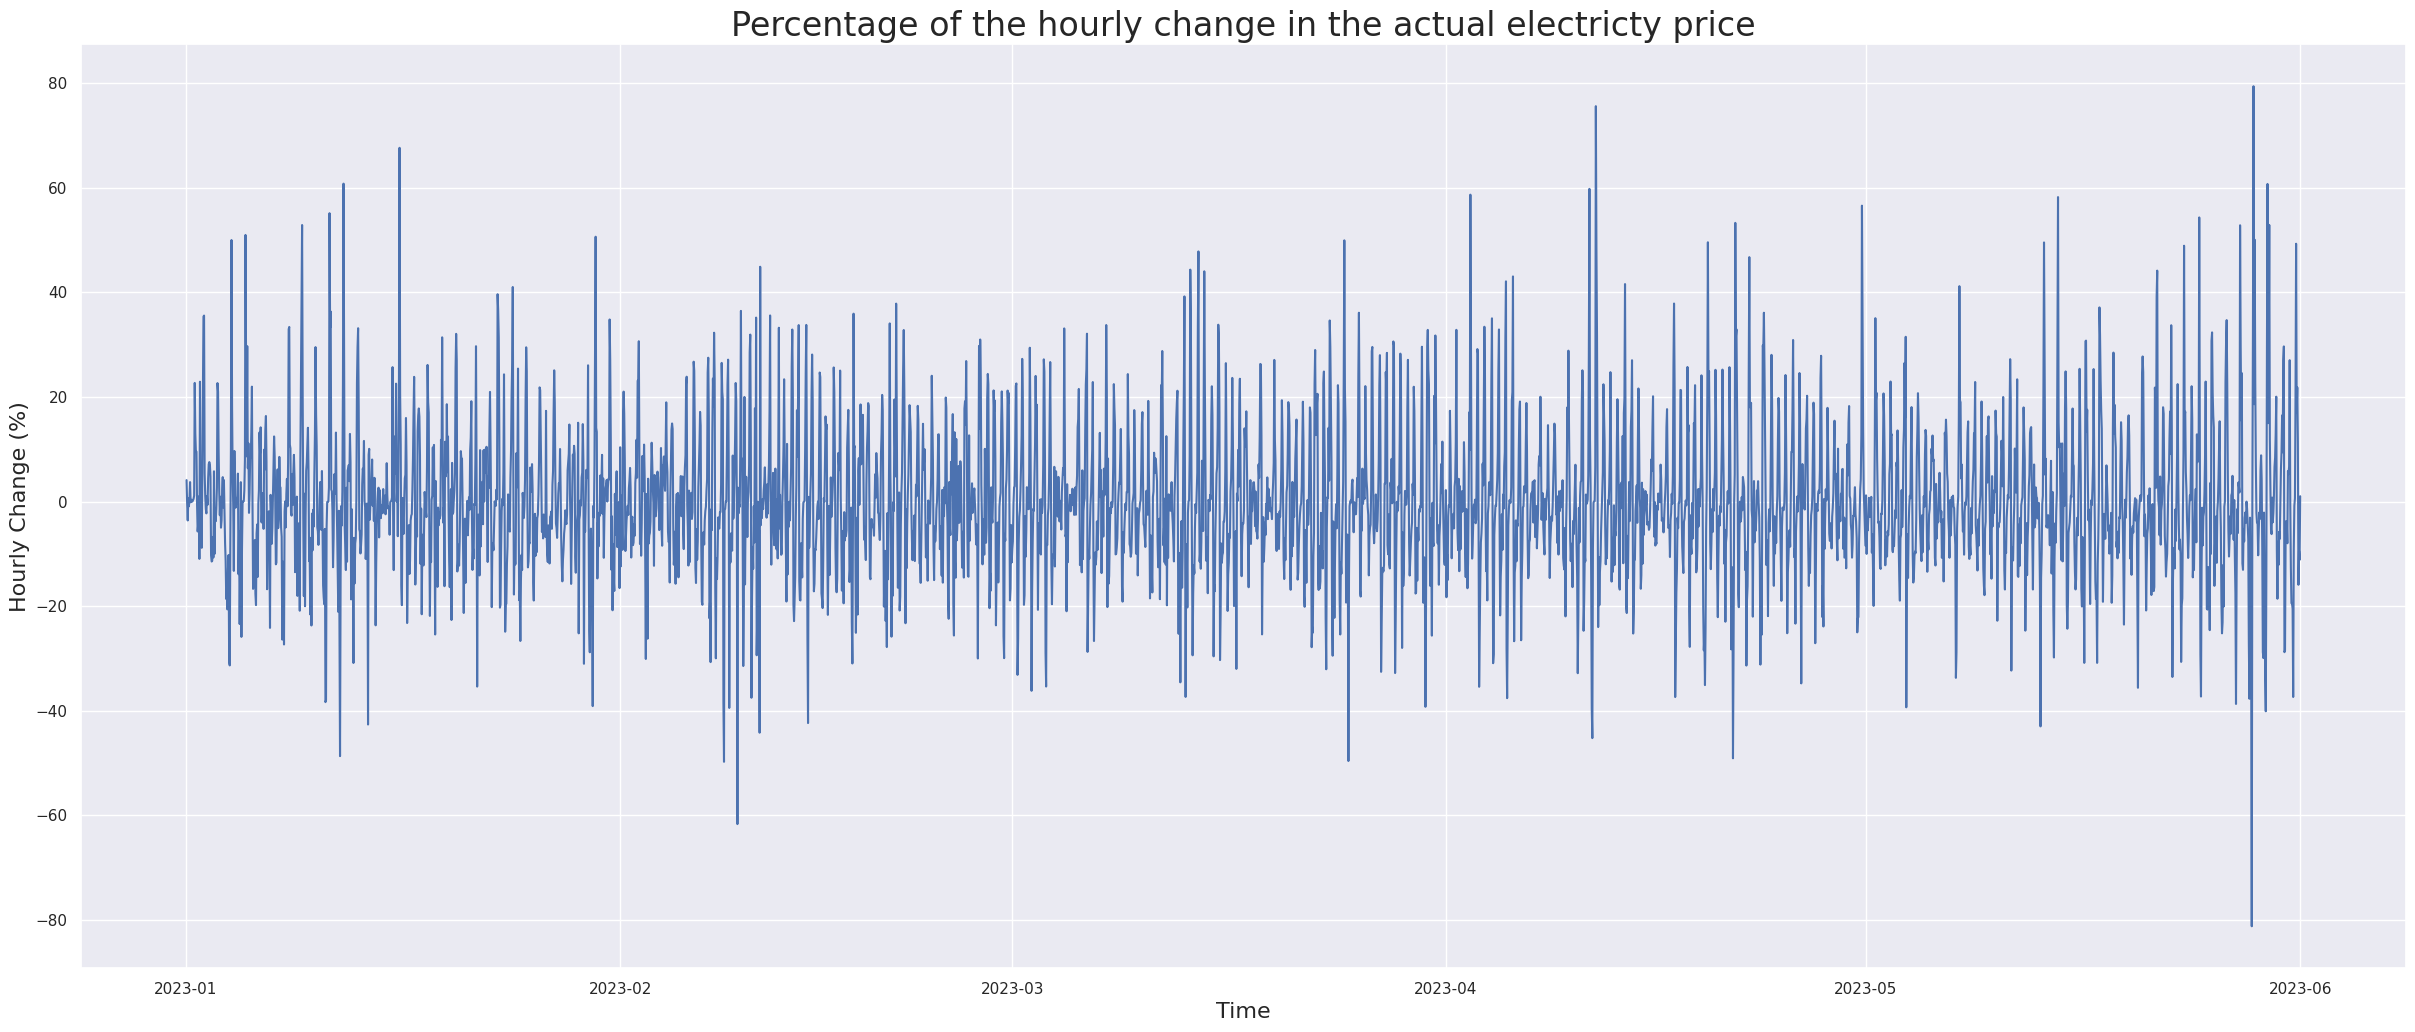

In [72]:
# Plot the percentage of the hourly change in the actual electricity price

# Calculate the hourly change in the actual electricity price but before normalize it
hourly_prices = df_final['day_ahead_price'].resample('H').mean()
change = hourly_prices.diff()
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -20% and +25%. However, there are also very few outliers which show that the price gets halved (-50%) or -80%.

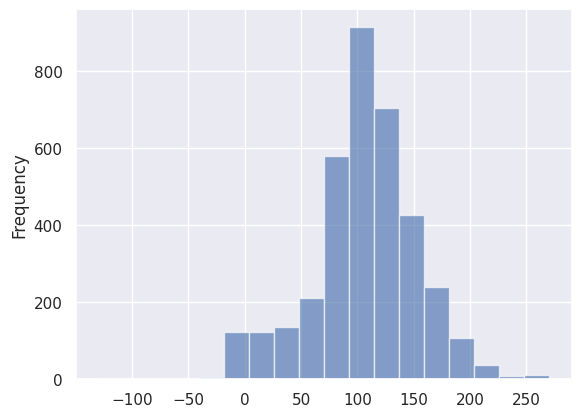

In [73]:
# Plot the histogram of the day ahead electricity price

ax = df_energy['day_ahead_price'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the day ahead energy price roughly follows a normal distribution and thus, could be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series.

## 2.2. Stationary Tests

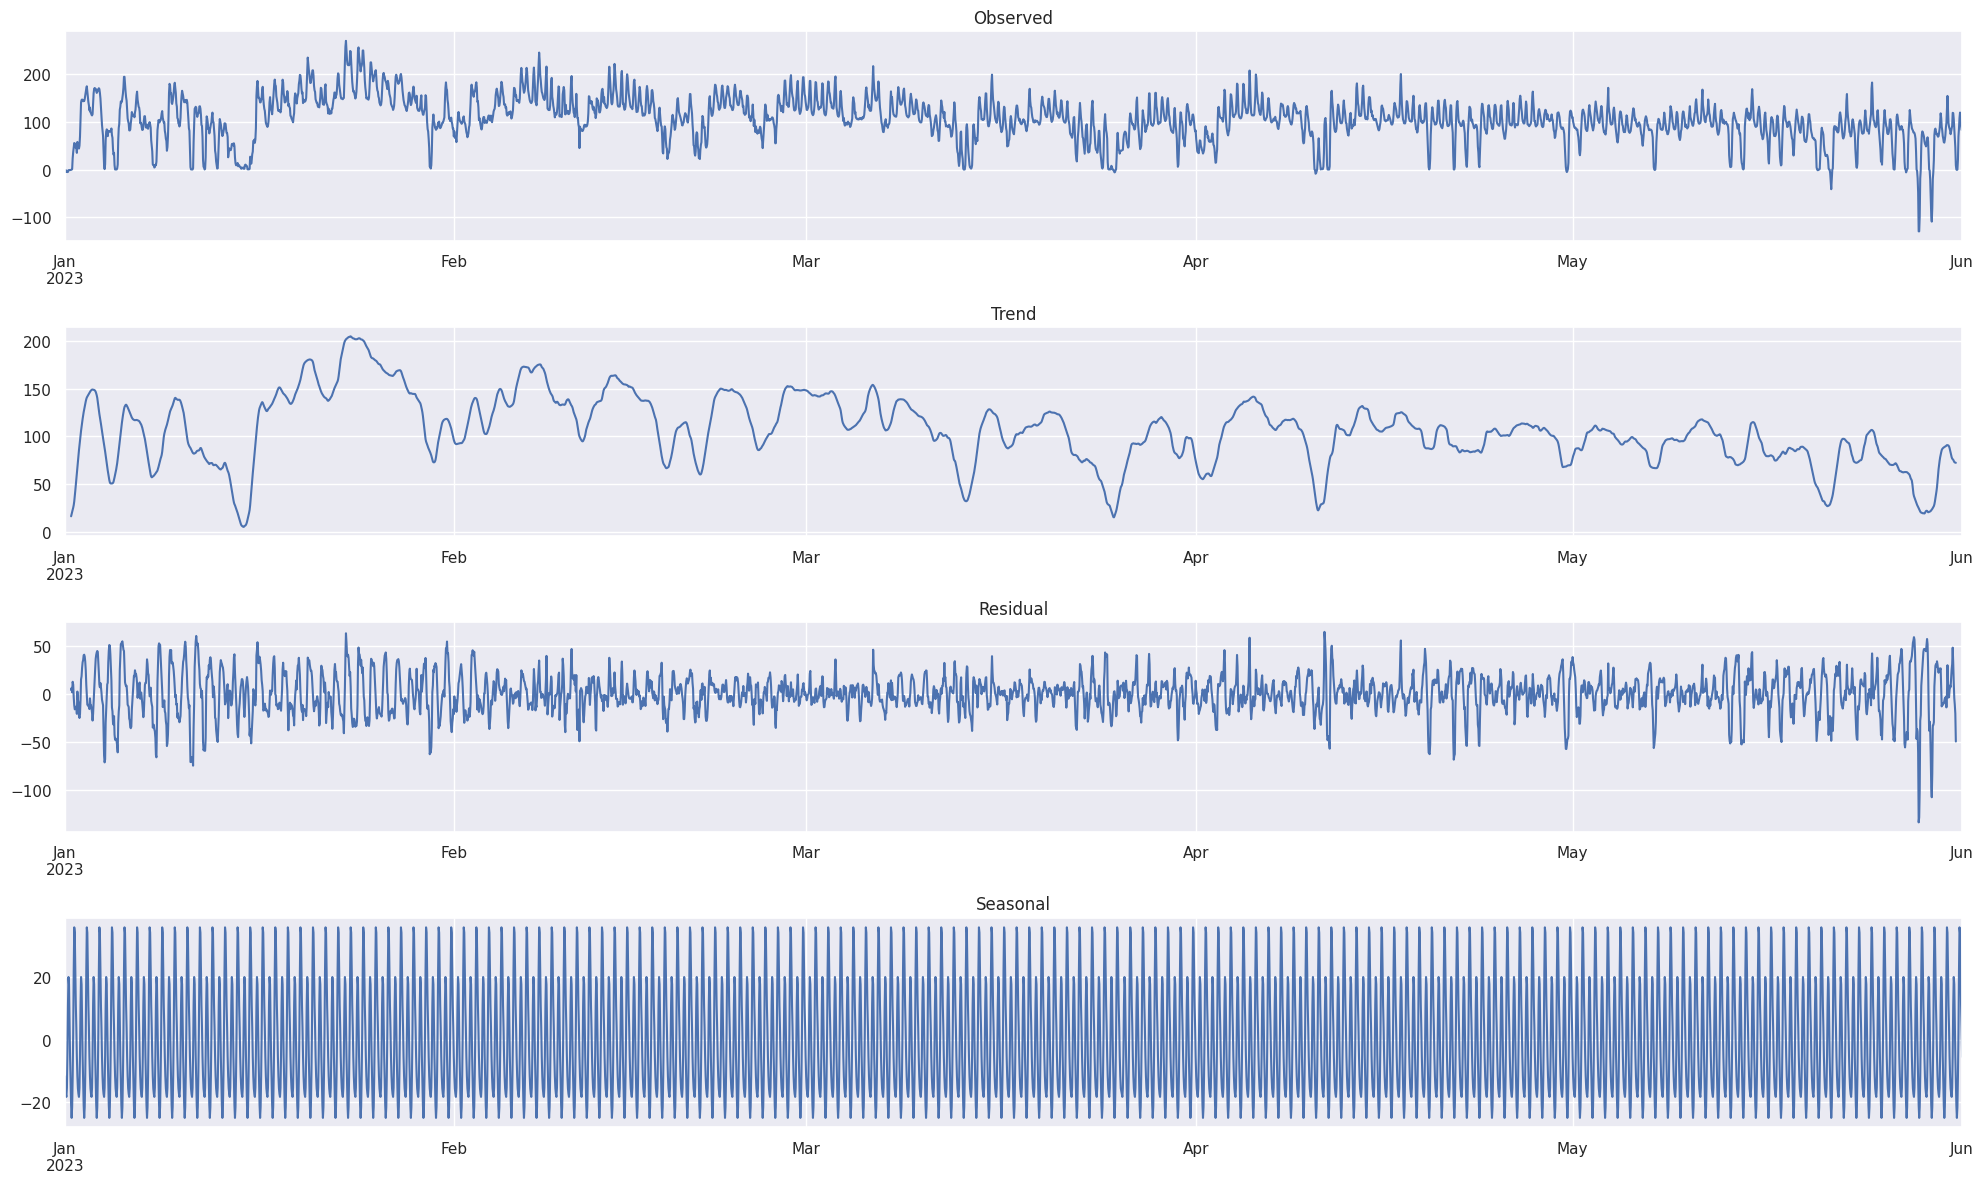

In [76]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['day_ahead_price'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The Augmented Dickey-Fuller (ADF) test, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:

* Null Hypothesis  H0: 
    There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
* Alternate Hypothesis  H1: 
    The time series has no unit root and is either stationary or can be made stationary using differencing

In [78]:
y = df_final['day_ahead_price']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -7.100222
p-value: 0.000000
#Lags used: 26
Critical Value (1%): -3.432166
Critical Value (5%): -2.862342
Critical Value (10%): -2.567197


The ADF statistic (-7.100222) is less than the critical value at 1% (-3.432) and thus, we can say that we reject the null hypothesis  H0
with a significance level 1%, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, follows the opposite logic from Augmented Dickey-Fuller test and checks for stationarity. Its hypotheses are the following:

* Null Hypothesis  H0: 
    The time series is level, i.e. it is stationary around a constant.
* Alternate Hypothesis  H1:
     There is a unit root in the time series and thus it not stationary.

In [80]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 2.326592
p-value: 0.010000
#Lags used: 30
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/tmp/ipykernel_212580/752821880.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(y, regression='c', nlags='legacy')


The KPSS statistic (2.326) is higher than the critical value at 1% (0.739) and thus, we can say that we cannot reject the null hypothesis  H0
with a significance level 1%, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity price time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

## 2.3 Autocorrelation, partial autocorrelation and cross-correlation

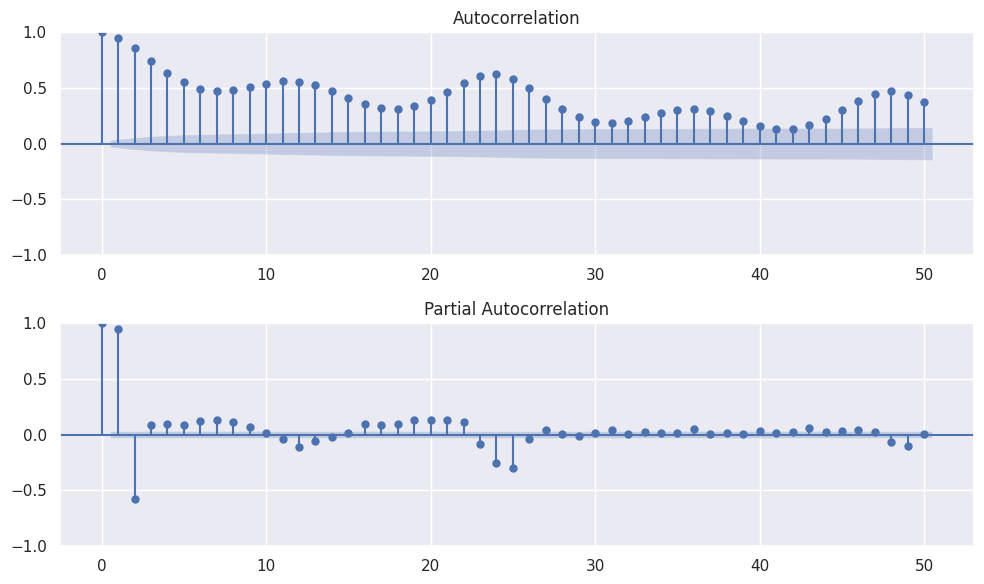

In [81]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['day_ahead_price'], lags=50, ax=ax1)
plot_pacf(df_final['day_ahead_price'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models.

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the electricity price and each one of the features in the dataset. For example, below we can see the cross-correlation between the electricity price and the actual load. We see that there are many time-lags with a correlation which is close to zero and could be ommited.

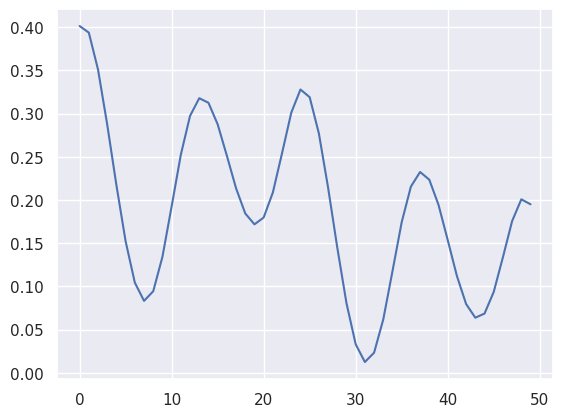

In [83]:
cross_corr = ccf(df_final['actual_load'], df_final['day_ahead_price'])
plt.plot(cross_corr[0:50])
plt.show()

In [84]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['day_ahead_price'].sort_values(ascending=False).to_string())

day_ahead_price                     1.000000
fossil_brown_coal/lignite           0.822934
fossil_gas                          0.772956
fossil_hard_coal                    0.684968
biomass                             0.565229
other_renewable                     0.545611
other                               0.532856
hydro_pumped_storage                0.466821
actual_load                         0.401463
relative_humidity_berlin            0.368624
geothermal                          0.323806
relative_humidity_munich            0.258292
nuclear                             0.241734
hydro_water_reservoir               0.102303
relative_humidity_frankfurt         0.084555
cloudiness_total_cover_berlin       0.030772
waste                               0.016491
wind_direction_berlin              -0.015790
wind_direction_frankfurt           -0.032589
visibility_frankfurt               -0.063832
cloudiness_total_cover_frankfurt   -0.083438
cloudiness_total_cover_munich      -0.090291
wind_direc

From the above, we can already see some very interesting correlations among the energy price that we want to predict and the rest of the features. For example, the total energy load and the amount of energy generated from sources related to fossil fuels, is positively correlated with the electricity price. In contrast, the wind speed in almost every city and the amount of storage energy cosumed through hydroelectric pumping is negatively correlated with the energy price.

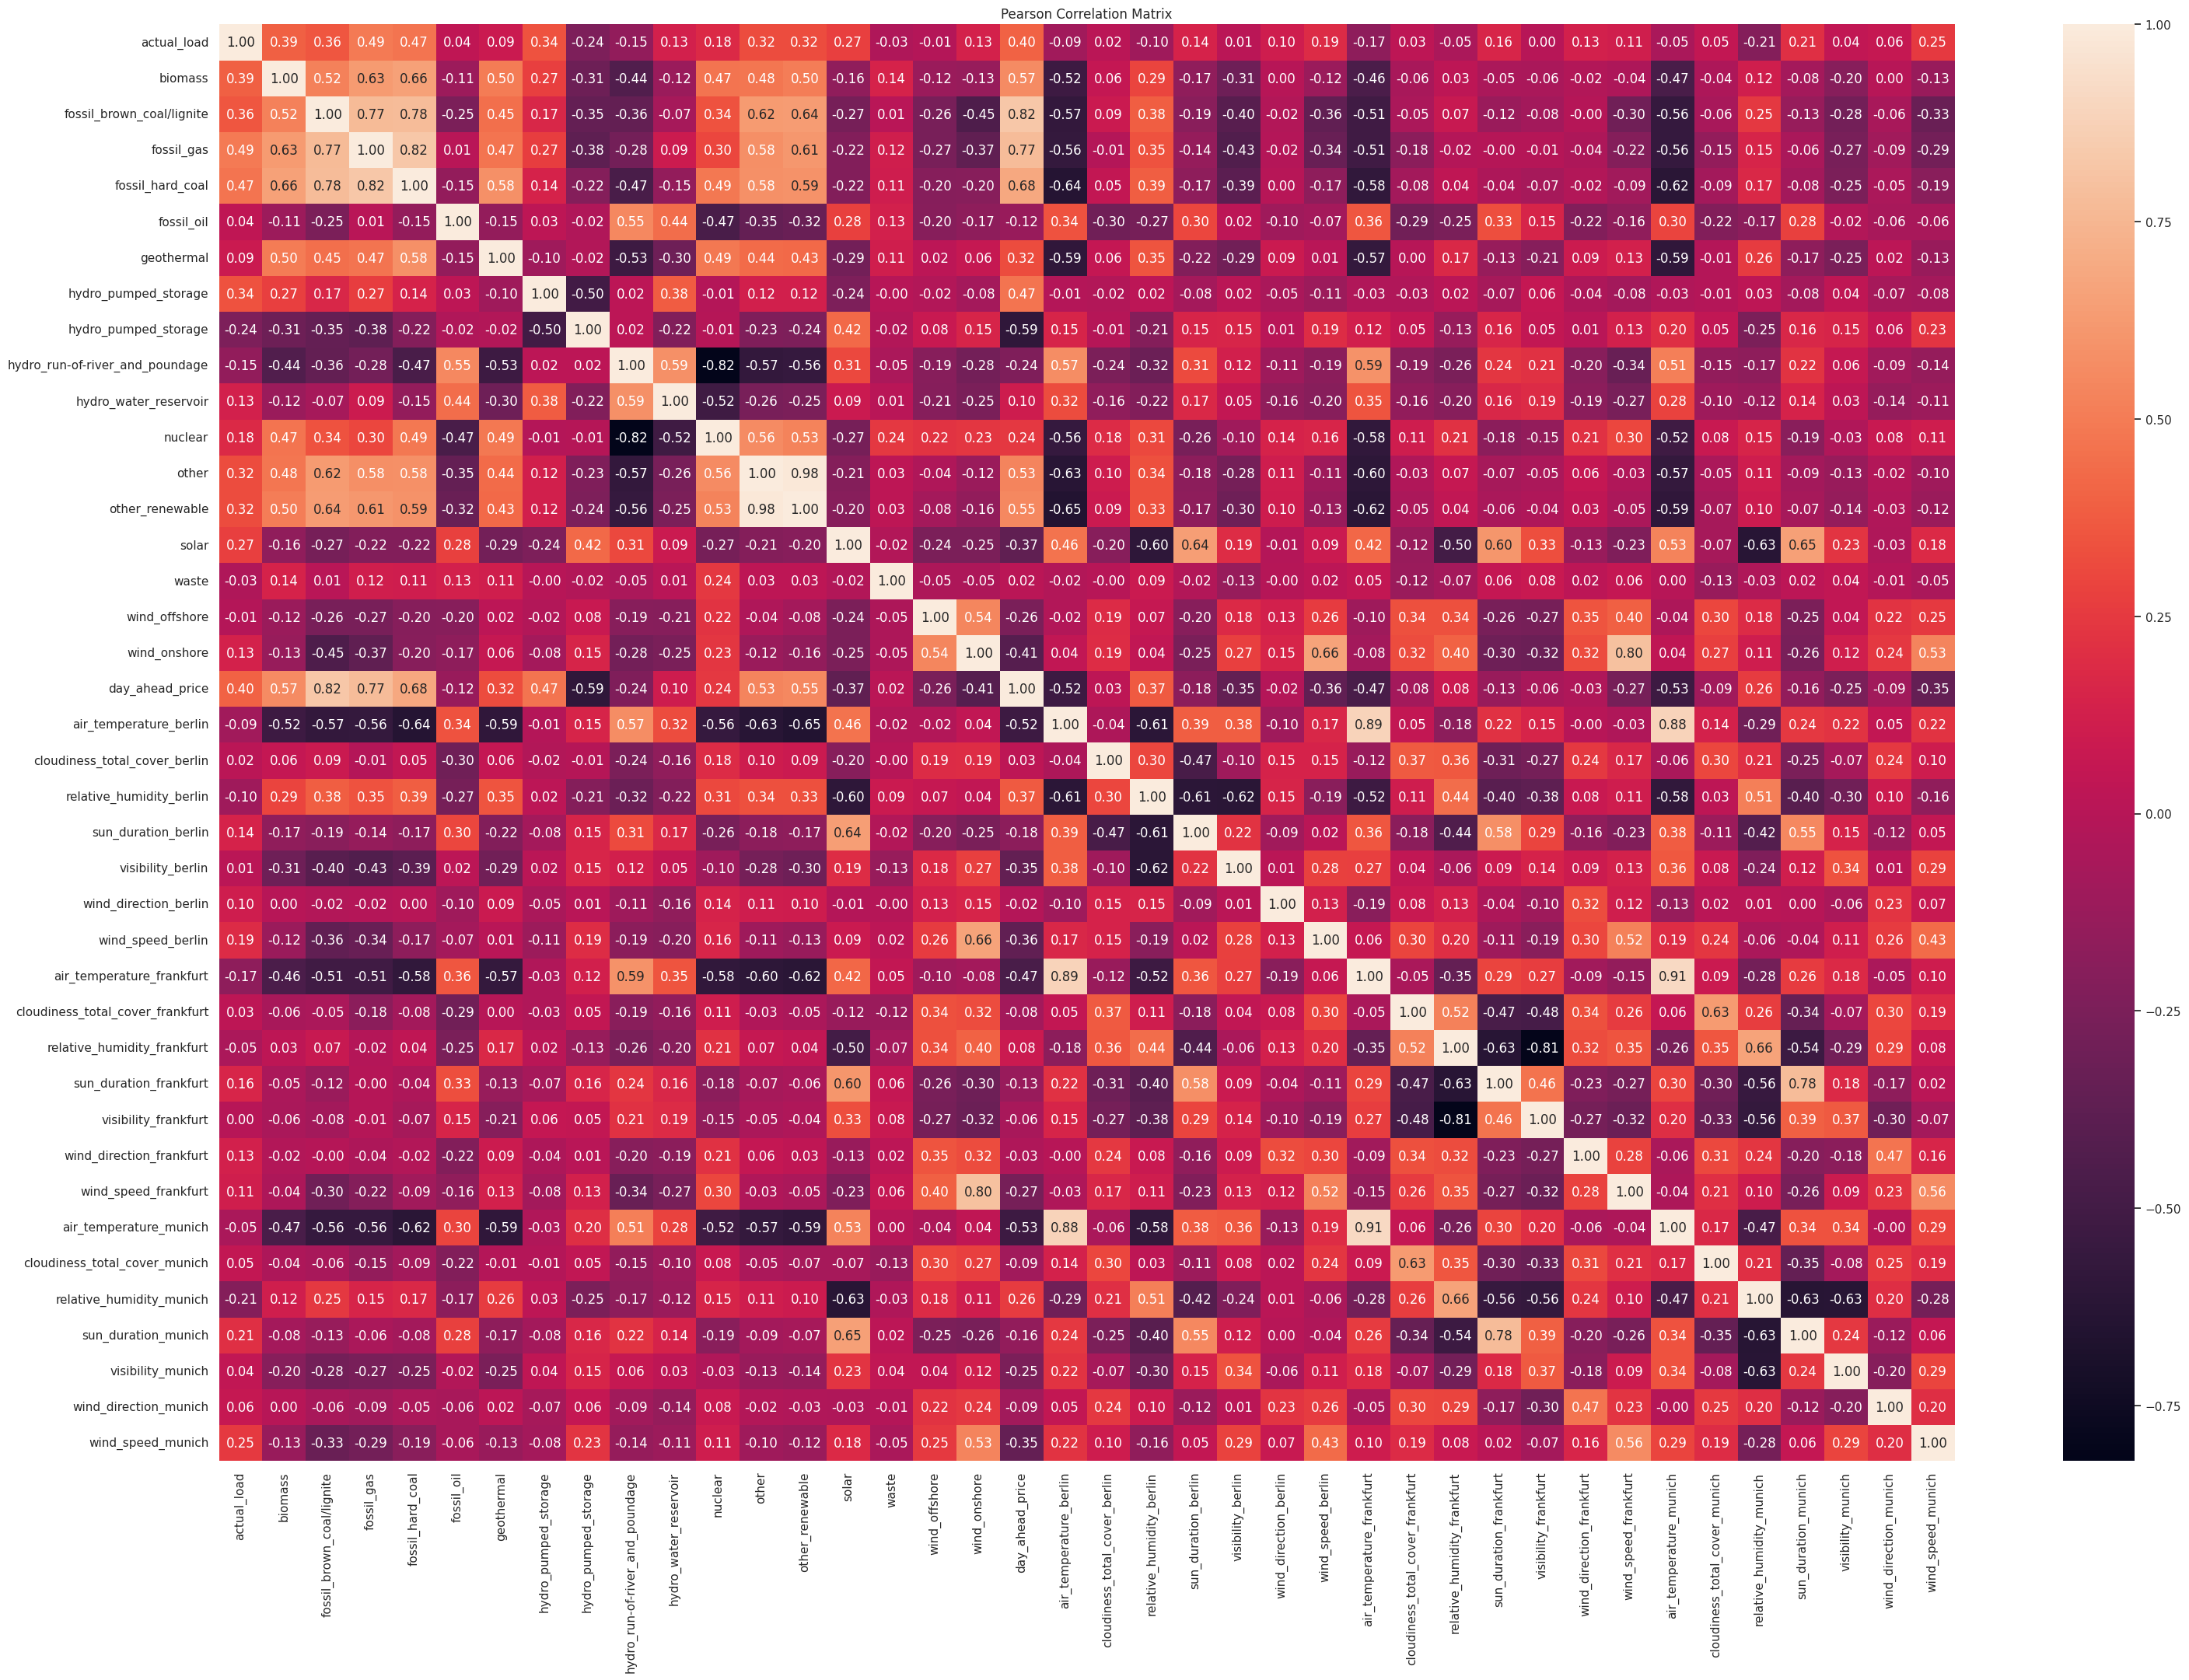

In [86]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(36, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [87]:
highly_correlated = abs(correlations[correlations > 0.60])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

biomass                           fossil_gas                          0.627797
                                  fossil_hard_coal                    0.657955
fossil_brown_coal/lignite         fossil_gas                          0.771910
                                  fossil_hard_coal                    0.778302
                                  other                               0.623928
                                  other_renewable                     0.636986
                                  day_ahead_price                     0.822934
fossil_gas                        biomass                             0.627797
                                  fossil_brown_coal/lignite           0.771910
                                  fossil_hard_coal                    0.824606
                                  other_renewable                     0.612606
                                  day_ahead_price                     0.772956
fossil_hard_coal                  biomass           

What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit, gas and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).

# 3. Feature Engineering